In [1]:
# Importing Libraries
print('Importing Libraries... ',end='')
import os
from pathlib import Path
import pandas as pd
import torchaudio
import zipfile
from torchaudio.transforms import Resample
import IPython.display as ipd
from matplotlib import pyplot as plt
from tqdm import tqdm
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
import torch
print('Done')

Importing Libraries... Done


In [2]:
# Loading dataset
path = Path('/home/user/Desktop/vamsi/class/Deep_Learning/Assignment_2')
df = pd.read_csv('/home/user/Desktop/vamsi/class/Deep_Learning/Assignment_2/meta/esc50.csv')

In [3]:
df.head()

filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

Shape of waveform: torch.Size([1, 220500])
Sample rate of waveform: 44100


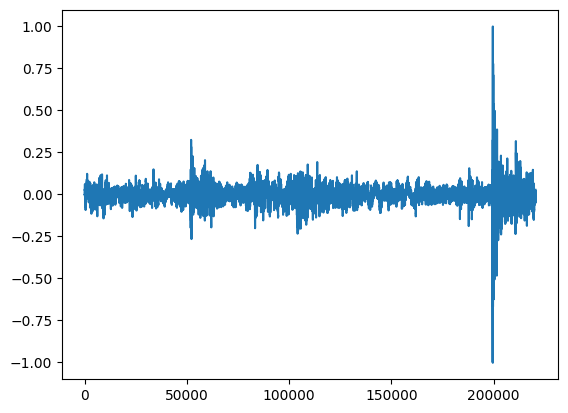

In [4]:
# Getting list of raw audio files
wavs = list(path.glob('audio/*'))  # List all audio files in the 'audio' directory using pathlib.Path.glob

# Visualizing data
waveform, sample_rate = torchaudio.load(wavs[1])  # Load the waveform and sample rate of the first audio file using torchaudio

print("Shape of waveform: {}".format(waveform.size()))  # Print the shape of the waveform tensor
print("Sample rate of waveform: {}".format(sample_rate))  # Print the sample rate of the audio file

# Plot the waveform using matplotlib
plt.figure()
plt.plot(waveform.t().numpy())  # Transpose and convert the waveform tensor to a NumPy array for plotting

# Display the audio using IPython.display.Audio
ipd.Audio(waveform, rate=sample_rate)  # Create an interactive audio player for the loaded waveform


In [5]:
class CustomDataset(Dataset):
    def __init__(self, dataset, **kwargs):
        # Initialize CustomDataset object with relevant parameters
        # dataset: "train", "val", or "test"
        # kwargs: Additional parameters like data directory, dataframe, folds, etc.

        # Extract parameters from kwargs
        self.data_directory = kwargs["data_directory"]
        self.data_frame = kwargs["data_frame"]
        self.validation_fold = kwargs["validation_fold"]
        self.testing_fold = kwargs["testing_fold"]
        self.esc_10_flag = kwargs["esc_10_flag"]
        self.file_column = kwargs["file_column"]
        self.label_column = kwargs["label_column"]
        self.sampling_rate = kwargs["sampling_rate"]
        self.new_sampling_rate = kwargs["new_sampling_rate"]
        self.sample_length_seconds = kwargs["sample_length_seconds"]

        # Filter dataframe based on esc_10_flag and data_type
        if self.esc_10_flag:
            self.data_frame = self.data_frame.loc[self.data_frame['esc10'] == True]

        if dataset == "train":
            self.data_frame = self.data_frame.loc[
                (self.data_frame['fold'] != self.validation_fold) & (self.data_frame['fold'] != self.testing_fold)]
        elif dataset == "val":
            self.data_frame = self.data_frame.loc[self.data_frame['fold'] == self.validation_fold]
        elif dataset == "test":
            self.data_frame = self.data_frame.loc[self.data_frame['fold'] == self.testing_fold]

        # Get unique categories from the filtered dataframe
        self.categories = sorted(self.data_frame[self.label_column].unique())

        # Initialize lists to hold file names, labels, and folder numbers
        self.file_names = []
        self.labels = []

        # Initialize dictionaries for category-to-index and index-to-category mapping
        self.category_to_index = {}
        self.index_to_category = {}

        for i, category in enumerate(self.categories):
            self.category_to_index[category] = i
            self.index_to_category[i] = category

        # Populate file names and labels lists by iterating through the dataframe
        for ind in tqdm(range(len(self.data_frame))):
            row = self.data_frame.iloc[ind]
            file_path = self.data_directory / "audio" / row[self.file_column]
            self.file_names.append(file_path)
            self.labels.append(self.category_to_index[row[self.label_column]])

        self.resampler = torchaudio.transforms.Resample(self.sampling_rate, self.new_sampling_rate)

        # Window size for rolling window sample splits (unfold method)
        if self.sample_length_seconds == 2:
            self.window_size = self.new_sampling_rate * 2
            self.step_size = int(self.new_sampling_rate * 0.75)
        else:
            self.window_size = self.new_sampling_rate
            self.step_size = int(self.new_sampling_rate * 0.5)

    def __getitem__(self, index):
        # Split audio files with overlap, pass as stacked tensors tensor with a single label
        path = self.file_names[index]
        audio_file = torchaudio.load(path, format=None, normalize=True)
        audio_tensor = self.resampler(audio_file[0])
        splits = audio_tensor.unfold(1, self.window_size, self.step_size)
        samples = splits.permute(1, 0, 2)
        return samples, self.labels[index]

    def __len__(self):
        return len(self.file_names)


In [6]:
class CustomDataModule(pl.LightningDataModule):
    def __init__(self, **kwargs):
        # Initialize the CustomDataModule with batch size, number of workers, and other parameters
        super().__init__()
        self.batch_size = kwargs["batch_size"]
        self.num_workers = kwargs["num_workers"]
        self.data_module_kwargs = kwargs

    def setup(self, stage=None):
        # Define datasets for training, validation, and testing during Lightning setup

        # If in 'fit' or None stage, create training and validation datasets
        if stage == 'fit' or stage is None:
            self.training_dataset = CustomDataset(dataset="train", **self.data_module_kwargs)
            self.validation_dataset = CustomDataset(dataset="val", **self.data_module_kwargs)

        # If in 'test' or None stage, create testing dataset
        if stage == 'test' or stage is None:
            self.testing_dataset = CustomDataset(dataset="test", **self.data_module_kwargs)

    def train_dataloader(self):
        # Return DataLoader for training dataset
        return DataLoader(self.training_dataset,
                          batch_size=self.batch_size,
                          shuffle=True,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def val_dataloader(self):
        # Return DataLoader for validation dataset
        return DataLoader(self.validation_dataset,
                          batch_size=self.batch_size,
                          shuffle=False,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def test_dataloader(self):
        # Return DataLoader for testing dataset
        return DataLoader(self.testing_dataset,
                          batch_size=32,
                          shuffle=False,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def collate_function(self, data):
        """
        Collate function to process a batch of examples and labels.

        Args:
            data: a tuple of 2 tuples with (example, label) where
                example are the split 1 second sub-frame audio tensors per file
                label = the label

        Returns:
            A list containing examples (concatenated tensors) and labels (flattened tensor).
        """
        examples, labels = zip(*data)
        examples = torch.cat(examples)
        labels = torch.flatten(torch.tensor(labels))

        return [examples, labels]


In [7]:
def setup_custom_data_module(k, test_samp=1, batch_size=4, num_workers=2):
    custom_data_module = CustomDataModule(batch_size=batch_size,
                                          num_workers=num_workers,
                                          data_directory=path,
                                          data_frame=df,
                                          validation_fold=k,
                                          testing_fold=test_samp,  # set to 0 for no test set
                                          esc_10_flag=True,
                                          file_column='filename',
                                          label_column='category',
                                          sampling_rate=44100,
                                          new_sampling_rate=16000,  # new sample rate for input
                                          sample_length_seconds=1  # new length of input in seconds
                                          )
    custom_data_module.setup()
    return custom_data_module


In [8]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
import matplotlib.pyplot as plt

def plot_metrics(train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list):
    # Plot training and validation losses
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_list, label='Training Accuracy')
    plt.plot(val_accuracy_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Evaluate the model on the test set
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    
    # Convert one-hot encoded labels to binary labels
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:
        y_true_binary = np.argmax(y_true, axis=1)
    else:
        y_true_binary = y_true
    
    return accuracy, cm, report, y_true_binary, y_pred# Evaluate the model

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def auc_roc_curve(model, test_loader, device, num_classes=10):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())

    true_labels = np.array(y_true)
    predicted_labels = np.argmax(np.array(y_scores), axis=1)

    true_labels_onehot = np.eye(num_classes)[true_labels]
    predicted_scores = np.eye(num_classes)[predicted_labels]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels_onehot[:, i], predicted_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 7))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [12]:
def evaluate_test(model, test_loader, criterion, device):

    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    # Calculate and store test accuracy
    test_accuracy = correct_test / total_test

    # Calculate and store average test loss
    test_loss /= len(test_loader)

    return test_loss, test_accuracy


# ARCHITECTURE - 1

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torchsummary import summary
from tqdm import tqdm

class SimpleCnn(nn.Module):
    def __init__(self, num_classes = 10, dropout_rate=0.5, weight_decay=0.001):
        super(SimpleCnn, self).__init__()
        self.conv1 = nn.Conv1d(1, 128, kernel_size=5, stride=4)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(4)
        self.fc_input_features = 512 * 14
        self.fc1 = nn.Linear(self.fc_input_features, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x =x.view(-1, 9, 1, 16000)
        x = x.mean(dim=1)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


k = 2  Validation Fold

In [18]:
k = 2  
custom_data_module = setup_custom_data_module(k)


100%|██████████| 80/80 [00:00<00:00, 5936.53it/s]


In [19]:
import wandb

model = SimpleCnn(num_classes = 10 , dropout_rate=0.5, weight_decay=0.001).to(device)

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)  # Use momentum here

val_loader = custom_data_module.val_dataloader()

# Define the early stopping parameters beacuse of resource constraints
patience = 25
best_val_loss = float('inf')
early_stop_counter = 0


wandb.init(
    project="Audio_Transformer", 
    config={
    "learning_rate": 0.0001,
    "architecture": "SimpleCnn",
    "dataset": "ESC",
    "epochs": 100,
    })

train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

num_epochs = 100

for epoch in range(num_epochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    model.train()
    for i, data in enumerate(custom_data_module.train_dataloader(), 0):
        inputs, labels = data

        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate and store training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_list.append(train_accuracy)

    # Calculate and store average training loss
    train_loss_list.append(train_loss / len(custom_data_module.train_dataloader()))

    wandb.log({"train_acc": train_accuracy, "train_loss": train_loss})

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data in custom_data_module.val_dataloader():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate and store validation accuracy
    val_accuracy = correct_val / total_val
    val_accuracy_list.append(val_accuracy)

    # Calculate and store average validation loss
    val_loss /= len(custom_data_module.val_dataloader())
    val_loss_list.append(val_loss)
    wandb.log({"val_acc": val_accuracy, "val_loss": val_loss})
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping!")
        break
wandb.finish()
print('Training Done')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vamsi8106 (vamsi_8106). Use `wandb login --relogin` to force relogin


Epoch 1/100, Training Accuracy: 0.1875, Validation Accuracy: 0.125, Validation Loss: 2.303138643503189
Epoch 2/100, Training Accuracy: 0.32916666666666666, Validation Accuracy: 0.375, Validation Loss: 1.7560824751853943
Epoch 3/100, Training Accuracy: 0.5041666666666667, Validation Accuracy: 0.4375, Validation Loss: 1.55217864215374
Epoch 4/100, Training Accuracy: 0.5541666666666667, Validation Accuracy: 0.5625, Validation Loss: 1.4629710882902145
Epoch 5/100, Training Accuracy: 0.6208333333333333, Validation Accuracy: 0.375, Validation Loss: 1.820336028933525
Epoch 6/100, Training Accuracy: 0.6583333333333333, Validation Accuracy: 0.45, Validation Loss: 1.4497232675552367
Epoch 7/100, Training Accuracy: 0.6625, Validation Accuracy: 0.55, Validation Loss: 1.4837712794542313
Epoch 8/100, Training Accuracy: 0.725, Validation Accuracy: 0.4625, Validation Loss: 1.427077504992485
Epoch 9/100, Training Accuracy: 0.6916666666666667, Validation Accuracy: 0.475, Validation Loss: 1.3954223185777

Training Done


In [20]:
test_loss, test_accuracy = evaluate_test(model, custom_data_module.test_dataloader(), criterion, device)
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')

Test Accuracy: 0.5625, Test Loss: 1.4154346187909443


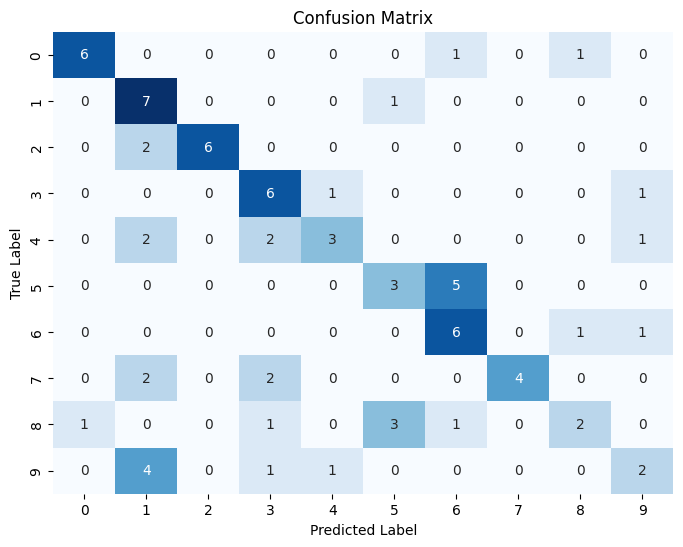

              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.41      0.88      0.56         8
           2       1.00      0.75      0.86         8
           3       0.50      0.75      0.60         8
           4       0.60      0.38      0.46         8
           5       0.43      0.38      0.40         8
           6       0.46      0.75      0.57         8
           7       1.00      0.50      0.67         8
           8       0.50      0.25      0.33         8
           9       0.40      0.25      0.31         8

    accuracy                           0.56        80
   macro avg       0.62      0.56      0.56        80
weighted avg       0.62      0.56      0.56        80



In [21]:
acc, cm, report, y_true, y_pred = evaluate_model(model, custom_data_module.test_dataloader(), device)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report with zero_division=1
print(classification_report(y_true, y_pred, zero_division=1))

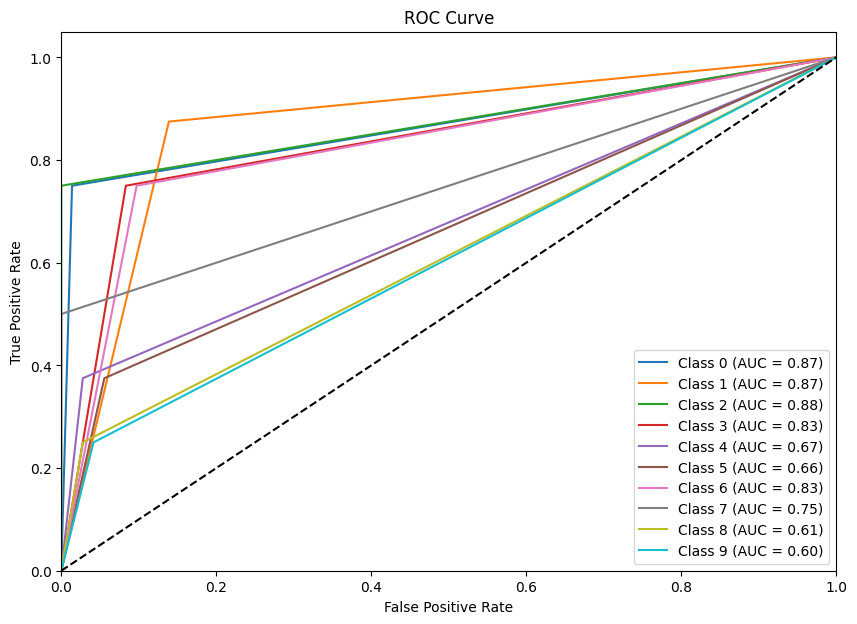

In [22]:
test_loader = custom_data_module.test_dataloader()
# Assuming you have `model`, `test_loader`, and `device` defined
auc_roc_curve(model, test_loader, device)

In [23]:

# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())

# Count the number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count the number of non-trainable parameters
non_trainable_params = total_params - trainable_params

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")


Total parameters: 1463306
Trainable parameters: 1463306
Non-trainable parameters: 0


 k = 3 Validation Fold

In [24]:
k = 3  
custom_data_module = setup_custom_data_module(k)


100%|██████████| 80/80 [00:00<00:00, 7826.84it/s]


In [25]:
import wandb

model = SimpleCnn(num_classes = 10 , dropout_rate=0.5, weight_decay=0.001).to(device)

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)  # Use momentum here

val_loader = custom_data_module.val_dataloader()

# Define the early stopping parameters
patience = 25
best_val_loss = float('inf')
early_stop_counter = 0


wandb.init(
    project="Audio_Transformer", 
    config={
    "learning_rate": 0.0001,
    "architecture": "SimpleCnn",
    "dataset": "ESC",
    "epochs": 100,
    })

train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

num_epochs = 100

for epoch in range(num_epochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    model.train()
    for i, data in enumerate(custom_data_module.train_dataloader(), 0):
        inputs, labels = data

        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate and store training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_list.append(train_accuracy)

    # Calculate and store average training loss
    train_loss_list.append(train_loss / len(custom_data_module.train_dataloader()))

    wandb.log({"train_acc": train_accuracy, "train_loss": train_loss})

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data in custom_data_module.val_dataloader():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate and store validation accuracy
    val_accuracy = correct_val / total_val
    val_accuracy_list.append(val_accuracy)

    # Calculate and store average validation loss
    val_loss /= len(custom_data_module.val_dataloader())
    val_loss_list.append(val_loss)
    wandb.log({"val_acc": val_accuracy, "val_loss": val_loss})
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping!")
        break
wandb.finish()
print('Training Done')


Epoch 1/100, Training Accuracy: 0.175, Validation Accuracy: 0.175, Validation Loss: 2.220634859800339
Epoch 2/100, Training Accuracy: 0.4, Validation Accuracy: 0.4, Validation Loss: 1.5745100900530815
Epoch 3/100, Training Accuracy: 0.4666666666666667, Validation Accuracy: 0.4125, Validation Loss: 1.5872522950172425
Epoch 4/100, Training Accuracy: 0.4875, Validation Accuracy: 0.4875, Validation Loss: 1.4385054767131806
Epoch 5/100, Training Accuracy: 0.6083333333333333, Validation Accuracy: 0.475, Validation Loss: 1.4133640810847283
Epoch 6/100, Training Accuracy: 0.675, Validation Accuracy: 0.4875, Validation Loss: 1.3407544776797296
Epoch 7/100, Training Accuracy: 0.675, Validation Accuracy: 0.45, Validation Loss: 1.4381842985749245
Epoch 8/100, Training Accuracy: 0.6875, Validation Accuracy: 0.525, Validation Loss: 1.14253938049078
Epoch 9/100, Training Accuracy: 0.725, Validation Accuracy: 0.45, Validation Loss: 1.3362314611673356
Epoch 10/100, Training Accuracy: 0.7666666666666667

Training Done


In [26]:
test_loss, test_accuracy = evaluate_test(model, custom_data_module.test_dataloader(), criterion, device)
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')

Test Accuracy: 0.4875, Test Loss: 1.382327953974406


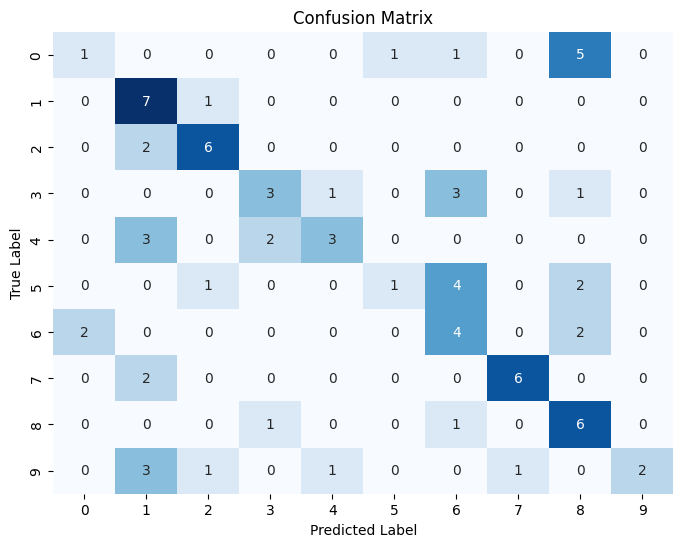

              precision    recall  f1-score   support

           0       0.33      0.12      0.18         8
           1       0.41      0.88      0.56         8
           2       0.67      0.75      0.71         8
           3       0.50      0.38      0.43         8
           4       0.60      0.38      0.46         8
           5       0.50      0.12      0.20         8
           6       0.31      0.50      0.38         8
           7       0.86      0.75      0.80         8
           8       0.38      0.75      0.50         8
           9       1.00      0.25      0.40         8

    accuracy                           0.49        80
   macro avg       0.56      0.49      0.46        80
weighted avg       0.56      0.49      0.46        80



In [27]:
acc, cm, report, y_true, y_pred = evaluate_model(model, custom_data_module.test_dataloader(), device)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# Print classification report with zero_division=1
print(classification_report(y_true, y_pred, zero_division=1))

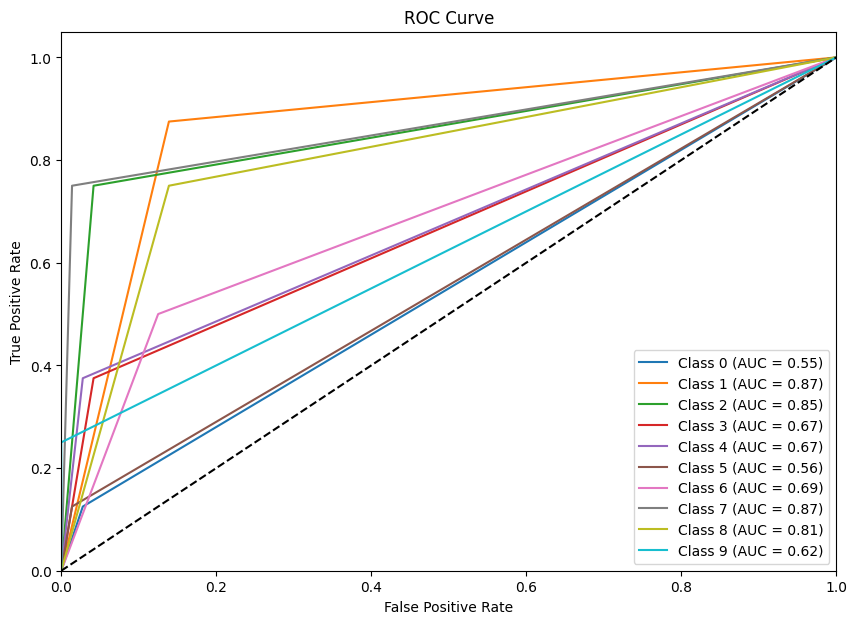

In [28]:
test_loader = custom_data_module.test_dataloader()
# Assuming you have `model`, `test_loader`, and `device` defined
auc_roc_curve(model, test_loader, device)

In [29]:

# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())

# Count the number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count the number of non-trainable parameters
non_trainable_params = total_params - trainable_params

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")


Total parameters: 1463306
Trainable parameters: 1463306
Non-trainable parameters: 0


k = 4 Validation Fold

In [41]:
k = 4
custom_data_module = setup_custom_data_module(k)

100%|██████████| 80/80 [00:00<00:00, 8415.33it/s]


In [42]:
import wandb

model = SimpleCnn(num_classes = 10 , dropout_rate=0.5, weight_decay=0.001).to(device)

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)  # Use momentum here

val_loader = custom_data_module.val_dataloader()

# Define the early stopping parameters
patience = 25
best_val_loss = float('inf')
early_stop_counter = 0


wandb.init(
    project="Audio_Transformer", 
    config={
    "learning_rate": 0.0001,
    "architecture": "SimpleCnn",
    "dataset": "ESC",
    "epochs": 100,
    })

train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

num_epochs = 100

for epoch in range(num_epochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    model.train()
    for i, data in enumerate(custom_data_module.train_dataloader(), 0):
        inputs, labels = data

        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate and store training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_list.append(train_accuracy)

    # Calculate and store average training loss
    train_loss_list.append(train_loss / len(custom_data_module.train_dataloader()))

    wandb.log({"train_acc": train_accuracy, "train_loss": train_loss})

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data in custom_data_module.val_dataloader():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate and store validation accuracy
    val_accuracy = correct_val / total_val
    val_accuracy_list.append(val_accuracy)

    # Calculate and store average validation loss
    val_loss /= len(custom_data_module.val_dataloader())
    val_loss_list.append(val_loss)
    wandb.log({"val_acc": val_accuracy, "val_loss": val_loss})
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping!")
        break
wandb.finish()
print('Training Done')


Epoch 1/100, Training Accuracy: 0.22916666666666666, Validation Accuracy: 0.15, Validation Loss: 2.2445787489414215
Epoch 2/100, Training Accuracy: 0.4041666666666667, Validation Accuracy: 0.3875, Validation Loss: 1.6652675092220306
Epoch 3/100, Training Accuracy: 0.48333333333333334, Validation Accuracy: 0.525, Validation Loss: 1.5372358202934264
Epoch 4/100, Training Accuracy: 0.5125, Validation Accuracy: 0.55, Validation Loss: 1.438365563750267
Epoch 5/100, Training Accuracy: 0.6291666666666667, Validation Accuracy: 0.575, Validation Loss: 1.363388752937317
Epoch 6/100, Training Accuracy: 0.6125, Validation Accuracy: 0.5375, Validation Loss: 1.3742525815963744
Epoch 7/100, Training Accuracy: 0.6375, Validation Accuracy: 0.6375, Validation Loss: 1.220128384232521
Epoch 8/100, Training Accuracy: 0.7208333333333333, Validation Accuracy: 0.5875, Validation Loss: 1.253705382347107
Epoch 9/100, Training Accuracy: 0.7458333333333333, Validation Accuracy: 0.6125, Validation Loss: 1.21384842

Training Done


In [43]:
test_loss, test_accuracy = evaluate_test(model, custom_data_module.test_dataloader(), criterion, device)
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')

Test Accuracy: 0.5375, Test Loss: 1.304507037003835


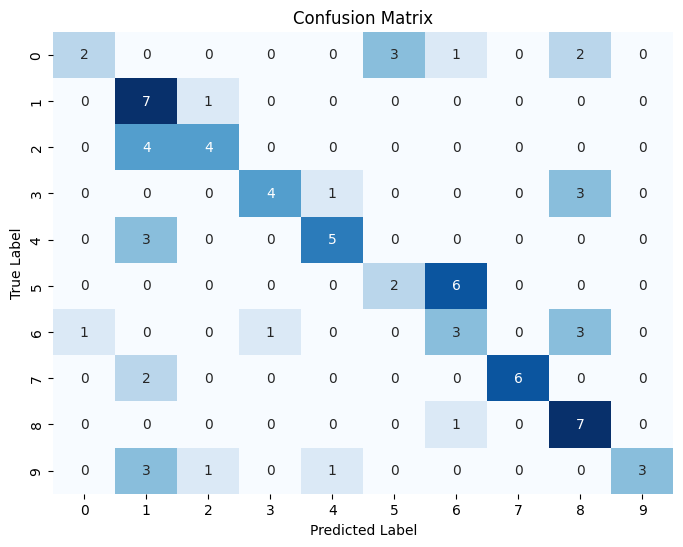

              precision    recall  f1-score   support

           0       0.67      0.25      0.36         8
           1       0.37      0.88      0.52         8
           2       0.67      0.50      0.57         8
           3       0.80      0.50      0.62         8
           4       0.71      0.62      0.67         8
           5       0.40      0.25      0.31         8
           6       0.27      0.38      0.32         8
           7       1.00      0.75      0.86         8
           8       0.47      0.88      0.61         8
           9       1.00      0.38      0.55         8

    accuracy                           0.54        80
   macro avg       0.64      0.54      0.54        80
weighted avg       0.64      0.54      0.54        80



In [44]:
acc, cm, report, y_true, y_pred = evaluate_model(model, custom_data_module.test_dataloader(), device)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# Print classification report with zero_division=1
print(classification_report(y_true, y_pred, zero_division=1))

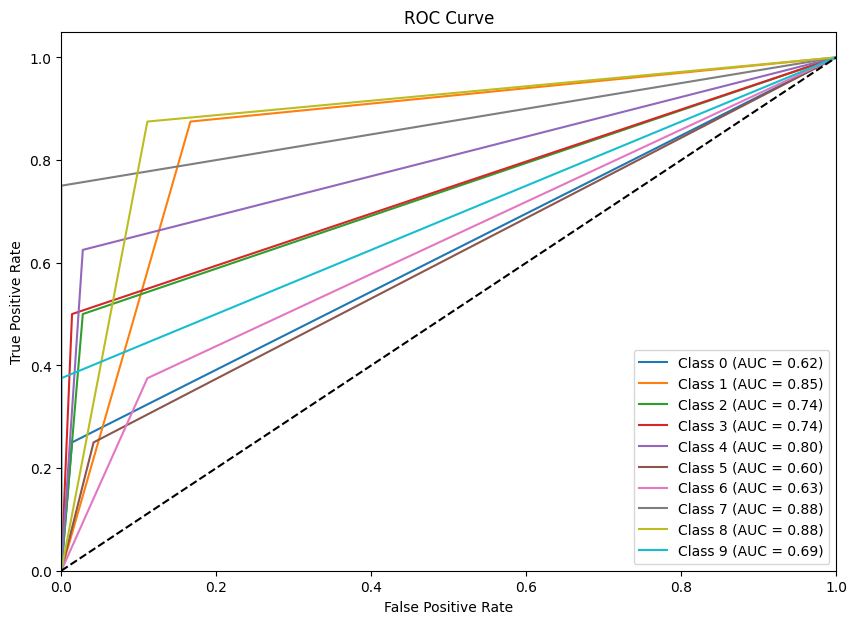

In [45]:
test_loader = custom_data_module.test_dataloader()
# Assuming you have `model`, `test_loader`, and `device` defined
auc_roc_curve(model, test_loader, device)

In [46]:
# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())

# Count the number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count the number of non-trainable parameters
non_trainable_params = total_params - trainable_params

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

Total parameters: 1463306
Trainable parameters: 1463306
Non-trainable parameters: 0


k = 5 Validation Fold

In [35]:
k = 5 
custom_data_module = setup_custom_data_module(k)

100%|██████████| 80/80 [00:00<00:00, 8622.71it/s]


In [36]:
import wandb

model = SimpleCnn(num_classes = 10 , dropout_rate=0.5, weight_decay=0.001).to(device)

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)  # Use momentum here

val_loader = custom_data_module.val_dataloader()

# Define the early stopping parameters
patience = 25
best_val_loss = float('inf')
early_stop_counter = 0


wandb.init(
    project="Audio_Transformer", 
    config={
    "learning_rate": 0.0001,
    "architecture": "SimpleCnn",
    "dataset": "ESC",
    "epochs": 100,
    })

train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

num_epochs = 100

for epoch in range(num_epochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    model.train()
    for i, data in enumerate(custom_data_module.train_dataloader(), 0):
        inputs, labels = data

        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate and store training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_list.append(train_accuracy)

    # Calculate and store average training loss
    train_loss_list.append(train_loss / len(custom_data_module.train_dataloader()))

    wandb.log({"train_acc": train_accuracy, "train_loss": train_loss})

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data in custom_data_module.val_dataloader():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate and store validation accuracy
    val_accuracy = correct_val / total_val
    val_accuracy_list.append(val_accuracy)

    # Calculate and store average validation loss
    val_loss /= len(custom_data_module.val_dataloader())
    val_loss_list.append(val_loss)
    wandb.log({"val_acc": val_accuracy, "val_loss": val_loss})
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping!")
        break
wandb.finish()
print('Training Done')

Epoch 1/100, Training Accuracy: 0.1875, Validation Accuracy: 0.1625, Validation Loss: 2.250937342643738
Epoch 2/100, Training Accuracy: 0.37916666666666665, Validation Accuracy: 0.5, Validation Loss: 1.7586986109614373
Epoch 3/100, Training Accuracy: 0.45416666666666666, Validation Accuracy: 0.5, Validation Loss: 1.5872057884931565
Epoch 4/100, Training Accuracy: 0.5125, Validation Accuracy: 0.5125, Validation Loss: 1.6354222111403942
Epoch 5/100, Training Accuracy: 0.6083333333333333, Validation Accuracy: 0.5625, Validation Loss: 1.5113009549677372
Epoch 6/100, Training Accuracy: 0.6666666666666666, Validation Accuracy: 0.525, Validation Loss: 1.4803043615072966
Epoch 7/100, Training Accuracy: 0.7083333333333334, Validation Accuracy: 0.55, Validation Loss: 1.4704673804342747
Epoch 8/100, Training Accuracy: 0.7666666666666667, Validation Accuracy: 0.55, Validation Loss: 1.4708904020488263
Epoch 9/100, Training Accuracy: 0.7625, Validation Accuracy: 0.55, Validation Loss: 1.451418651640

Training Done


In [37]:
test_loss, test_accuracy = evaluate_test(model, custom_data_module.test_dataloader(), criterion, device)
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')

Test Accuracy: 0.4875, Test Loss: 1.6774722735087078


/home/user/anaconda3/envs/dl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/anaconda3/envs/dl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/anaconda3/envs/dl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


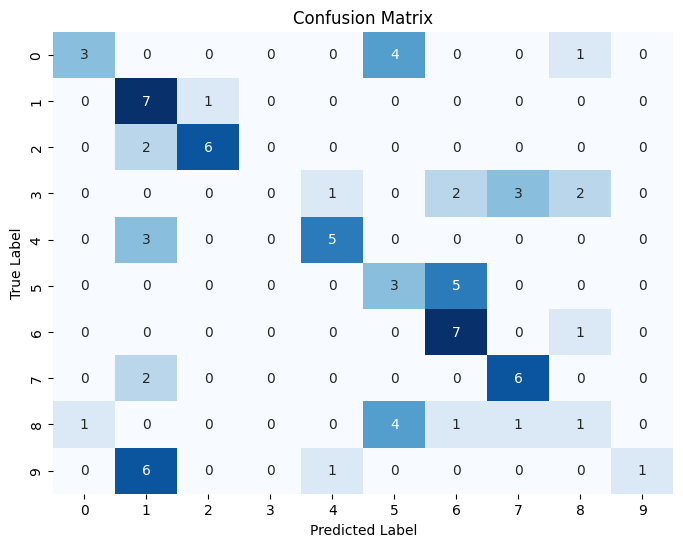

              precision    recall  f1-score   support

           0       0.75      0.38      0.50         8
           1       0.35      0.88      0.50         8
           2       0.86      0.75      0.80         8
           3       1.00      0.00      0.00         8
           4       0.71      0.62      0.67         8
           5       0.27      0.38      0.32         8
           6       0.47      0.88      0.61         8
           7       0.60      0.75      0.67         8
           8       0.20      0.12      0.15         8
           9       1.00      0.12      0.22         8

    accuracy                           0.49        80
   macro avg       0.62      0.49      0.44        80
weighted avg       0.62      0.49      0.44        80



In [38]:
acc, cm, report, y_true, y_pred = evaluate_model(model, custom_data_module.test_dataloader(), device)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# Print classification report with zero_division=1
print(classification_report(y_true, y_pred, zero_division=1))

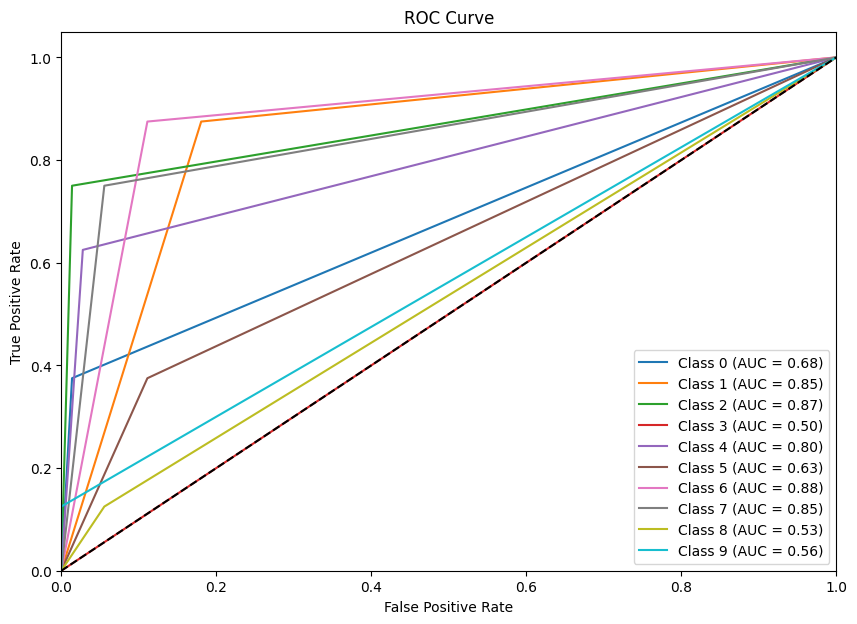

In [39]:
test_loader = custom_data_module.test_dataloader()
# Assuming you have `model`, `test_loader`, and `device` defined
auc_roc_curve(model, test_loader, device)


In [40]:
# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())

# Count the number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count the number of non-trainable parameters
non_trainable_params = total_params - trainable_params

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")


Total parameters: 1463306
Trainable parameters: 1463306
Non-trainable parameters: 0


# ARCHITECTURE - 2

In [96]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torchsummary import summary
from tqdm import tqdm

class SimpleCnn(nn.Module):
    def __init__(self, num_classes = 10, dropout_rate=0.5, weight_decay=0.001):
        super(SimpleCnn, self).__init__()
        self.conv1 = nn.Conv1d(1, 128, kernel_size=5, stride=4)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(4)
        self.fc_input_features = 512 * 14
        self.fc1 = nn.Linear(self.fc_input_features, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x =x.view(-1, 9, 1, 16000)
        x = x.mean(dim=1)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x


In [97]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the multi-head self-attention mechanism
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.num_heads = num_heads
        self.d_head = d_model // num_heads
        self.linear_query = nn.Linear(d_model, d_model)
        self.linear_key = nn.Linear(d_model, d_model)
        self.linear_value = nn.Linear(d_model, d_model)
        self.linear_out = nn.Linear(d_model, d_model)

    def forward(self, query, key, value):
        batch_size = query.size(0)

        # Linear transformations for query, key, and value
        query = self.linear_query(query).view(batch_size, -1, self.num_heads, self.d_head).transpose(1, 2)  # (batch_size, num_heads, query_len, d_head)
        key = self.linear_key(key).view(batch_size, -1, self.num_heads, self.d_head).transpose(1, 2)  # (batch_size, num_heads, key_len, d_head)
        value = self.linear_value(value).view(batch_size, -1, self.num_heads, self.d_head).transpose(1, 2)  # (batch_size, num_heads, value_len, d_head)

        # Scaled dot-product attention
        scores = torch.matmul(query, key.transpose(-2, -1)) / (self.d_head ** 0.5)  # (batch_size, num_heads, query_len, key_len)
        attn_weights = F.softmax(scores, dim=-1)
        attn_output = torch.matmul(attn_weights, value)  # (batch_size, num_heads, query_len, d_head)

        # Concatenate and linear transformation
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_head)  # (batch_size, query_len, num_heads * d_head)
        attn_output = self.linear_out(attn_output)  # (batch_size, query_len, d_model)

        return attn_output

# Define the Transformer encoder block with regularization
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, dropout_rate=0.5, l2_reg=1e-5):
        super(TransformerEncoderBlock, self).__init__()
        self.multihead_attn = MultiHeadAttention(d_model, num_heads)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.feedforward = nn.Sequential(
            nn.Linear(d_model, 2 * d_model),
            nn.ReLU(),
            nn.Linear(2 * d_model, d_model)
        )
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.l2_reg = l2_reg

        # Initialize the linear layers using Xavier initialization
        for module in [self.multihead_attn.linear_query, self.multihead_attn.linear_key, self.multihead_attn.linear_value, self.multihead_attn.linear_out]:
            nn.init.xavier_uniform_(module.weight)

    def forward(self, x):
        attn_output = self.multihead_attn(x, x, x)
        x = self.layer_norm1(x + self.dropout1(attn_output))
        ff_output = self.feedforward(x)
        x = self.layer_norm2(x + self.dropout2(ff_output))
        return x

# Define the complete model with regularization
class AudioClassifierRegularized(nn.Module):
    def __init__(self, num_classes, num_heads, dropout_rate=0.5, l2_reg=1e-5):
        super(AudioClassifierRegularized, self).__init__()
        self.base = SimpleCnn(dropout_rate=dropout_rate, weight_decay=l2_reg, num_classes=256)
        self.transformer_block1 = TransformerEncoderBlock(256, num_heads, dropout_rate, l2_reg)
        self.transformer_block2 = TransformerEncoderBlock(256, num_heads, dropout_rate, l2_reg)
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),  # Apply ReLU before the final linear layer for better non-linearity
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

        # Initialize the linear layers using Xavier initialization
        for module in [self.fc[0], self.fc[3]]:
            nn.init.xavier_uniform_(module.weight)

    def forward(self, x):
        x = self.base(x)
        x = self.transformer_block1(x)
        x = self.transformer_block2(x)
        cls_token = x[:, 0, :]  # Use <cls> token for classification
        output = self.fc(cls_token)
        return F.log_softmax(output, dim=1)


k = 2 Validation Fold

In [98]:
k = 2 
custom_data_module = setup_custom_data_module(k)

100%|██████████| 80/80 [00:00<00:00, 6187.89it/s]


Heads in Attention block = 1

In [99]:
# Initialize the model
num_classes = 10
num_heads = 1 # You can change the number of heads as needed
model = AudioClassifierRegularized(num_classes, num_heads).to(device)

In [100]:
import wandb

model = SimpleCnn(num_classes = 10 , dropout_rate=0.5, weight_decay=0.001).to(device)

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.95)  # Use momentum here

val_loader = custom_data_module.val_dataloader()

# Define the early stopping parameters
patience = 25
best_val_loss = float('inf')
early_stop_counter = 0


wandb.init(
    project="Audio_Transformer", 
    config={
    "learning_rate": 0.0001,
    "architecture": "SimpleCnn",
    "dataset": "ESC",
    "epochs": 100,
    })

train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

num_epochs = 100

for epoch in range(num_epochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    model.train()
    for i, data in enumerate(custom_data_module.train_dataloader(), 0):
        inputs, labels = data

        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate and store training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_list.append(train_accuracy)

    # Calculate and store average training loss
    train_loss_list.append(train_loss / len(custom_data_module.train_dataloader()))

    wandb.log({"train_acc": train_accuracy, "train_loss": train_loss})

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data in custom_data_module.val_dataloader():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate and store validation accuracy
    val_accuracy = correct_val / total_val
    val_accuracy_list.append(val_accuracy)

    # Calculate and store average validation loss
    val_loss /= len(custom_data_module.val_dataloader())
    val_loss_list.append(val_loss)
    wandb.log({"val_acc": val_accuracy, "val_loss": val_loss})
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping!")
        break
wandb.finish()
print('Training Done')

Epoch 1/100, Training Accuracy: 0.22916666666666666, Validation Accuracy: 0.175, Validation Loss: 2.748167854547501
Epoch 2/100, Training Accuracy: 0.43333333333333335, Validation Accuracy: 0.2625, Validation Loss: 2.5201559722423554
Epoch 3/100, Training Accuracy: 0.44166666666666665, Validation Accuracy: 0.35, Validation Loss: 1.8628826498985291
Epoch 4/100, Training Accuracy: 0.6, Validation Accuracy: 0.35, Validation Loss: 1.7552790135145186
Epoch 5/100, Training Accuracy: 0.6166666666666667, Validation Accuracy: 0.5625, Validation Loss: 1.7303248181939126
Epoch 6/100, Training Accuracy: 0.6416666666666667, Validation Accuracy: 0.4625, Validation Loss: 1.476461061835289
Epoch 7/100, Training Accuracy: 0.725, Validation Accuracy: 0.5375, Validation Loss: 1.3953613102436067
Epoch 8/100, Training Accuracy: 0.725, Validation Accuracy: 0.4625, Validation Loss: 1.7789164066314698
Epoch 9/100, Training Accuracy: 0.8083333333333333, Validation Accuracy: 0.4875, Validation Loss: 1.683609694

Training Done


In [101]:
test_loss, test_accuracy = evaluate_test(model, custom_data_module.test_dataloader(), criterion, device)
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')

Test Accuracy: 0.45, Test Loss: 2.041909615198771


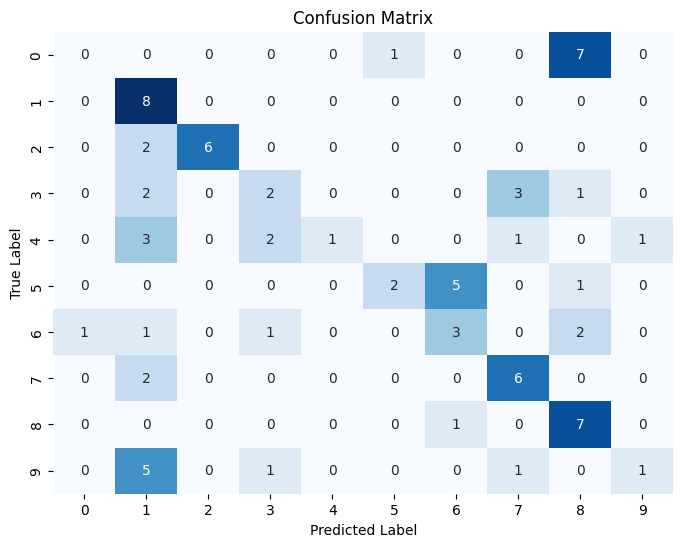

              precision    recall  f1-score   support

           0       0.00      0.00      1.00         8
           1       0.35      1.00      0.52         8
           2       1.00      0.75      0.86         8
           3       0.33      0.25      0.29         8
           4       1.00      0.12      0.22         8
           5       0.67      0.25      0.36         8
           6       0.33      0.38      0.35         8
           7       0.55      0.75      0.63         8
           8       0.39      0.88      0.54         8
           9       0.50      0.12      0.20         8

    accuracy                           0.45        80
   macro avg       0.51      0.45      0.50        80
weighted avg       0.51      0.45      0.50        80



In [102]:
acc, cm, report, y_true, y_pred = evaluate_model(model, custom_data_module.test_dataloader(), device)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# Print classification report with zero_division=1
print(classification_report(y_true, y_pred, zero_division=1))

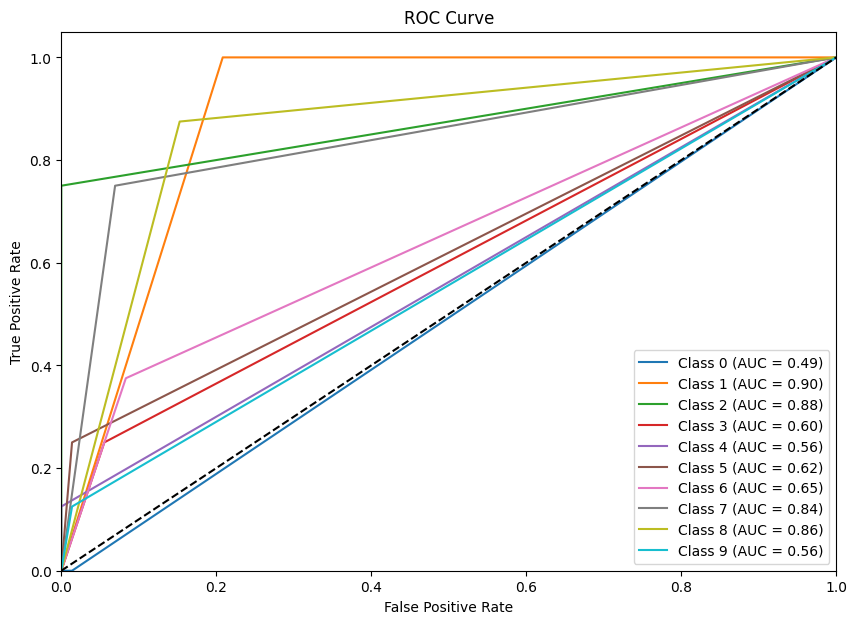

In [103]:
test_loader = custom_data_module.test_dataloader()
# Assuming you have `model`, `test_loader`, and `device` defined
auc_roc_curve(model, test_loader, device)

In [104]:
# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())

# Count the number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count the number of non-trainable parameters
non_trainable_params = total_params - trainable_params

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

Total parameters: 616074
Trainable parameters: 616074
Non-trainable parameters: 0


Heads in Attention block = 2

In [105]:
# Initialize the model
num_classes = 10
num_heads = 2 # You can change the number of heads as needed
model = AudioClassifierRegularized(num_classes, num_heads).to(device)

In [106]:
import wandb

model = SimpleCnn(num_classes = 10 , dropout_rate=0.5, weight_decay=0.001).to(device)

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.95)  # Use momentum here

val_loader = custom_data_module.val_dataloader()

# Define the early stopping parameters
patience = 25
best_val_loss = float('inf')
early_stop_counter = 0


wandb.init(
    project="Audio_Transformer", 
    config={
    "learning_rate": 0.0001,
    "architecture": "SimpleCnn",
    "dataset": "ESC",
    "epochs": 100,
    })

train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

num_epochs = 100

for epoch in range(num_epochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    model.train()
    for i, data in enumerate(custom_data_module.train_dataloader(), 0):
        inputs, labels = data

        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate and store training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_list.append(train_accuracy)

    # Calculate and store average training loss
    train_loss_list.append(train_loss / len(custom_data_module.train_dataloader()))

    wandb.log({"train_acc": train_accuracy, "train_loss": train_loss})

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data in custom_data_module.val_dataloader():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate and store validation accuracy
    val_accuracy = correct_val / total_val
    val_accuracy_list.append(val_accuracy)

    # Calculate and store average validation loss
    val_loss /= len(custom_data_module.val_dataloader())
    val_loss_list.append(val_loss)
    wandb.log({"val_acc": val_accuracy, "val_loss": val_loss})
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping!")
        break
wandb.finish()
print('Training Done')

Epoch 1/100, Training Accuracy: 0.20833333333333334, Validation Accuracy: 0.2, Validation Loss: 3.056270253658295
Epoch 2/100, Training Accuracy: 0.3625, Validation Accuracy: 0.3875, Validation Loss: 1.9007271885871888
Epoch 3/100, Training Accuracy: 0.5, Validation Accuracy: 0.35, Validation Loss: 1.7715816378593445
Epoch 4/100, Training Accuracy: 0.6166666666666667, Validation Accuracy: 0.575, Validation Loss: 1.362431812286377
Epoch 5/100, Training Accuracy: 0.6375, Validation Accuracy: 0.475, Validation Loss: 1.6685806185007095
Epoch 6/100, Training Accuracy: 0.5916666666666667, Validation Accuracy: 0.4375, Validation Loss: 1.8085430443286896
Epoch 7/100, Training Accuracy: 0.6958333333333333, Validation Accuracy: 0.5375, Validation Loss: 1.7101720869541168
Epoch 8/100, Training Accuracy: 0.7125, Validation Accuracy: 0.4125, Validation Loss: 1.657389184832573
Epoch 9/100, Training Accuracy: 0.7333333333333333, Validation Accuracy: 0.4125, Validation Loss: 1.9419602267444134
Epoch 1

Training Done


In [107]:
test_loss, test_accuracy = evaluate_test(model, custom_data_module.test_dataloader(), criterion, device)
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')


Test Accuracy: 0.55, Test Loss: 1.467514415582021


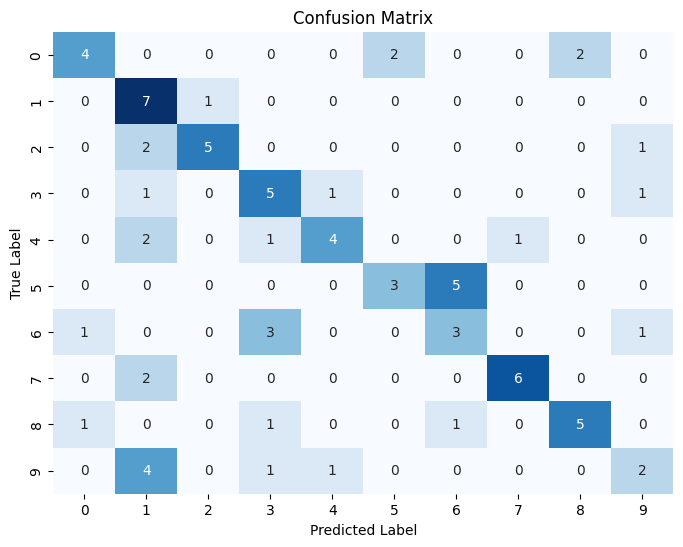

              precision    recall  f1-score   support

           0       0.67      0.50      0.57         8
           1       0.39      0.88      0.54         8
           2       0.83      0.62      0.71         8
           3       0.45      0.62      0.53         8
           4       0.67      0.50      0.57         8
           5       0.60      0.38      0.46         8
           6       0.33      0.38      0.35         8
           7       0.86      0.75      0.80         8
           8       0.71      0.62      0.67         8
           9       0.40      0.25      0.31         8

    accuracy                           0.55        80
   macro avg       0.59      0.55      0.55        80
weighted avg       0.59      0.55      0.55        80



In [108]:
acc, cm, report, y_true, y_pred = evaluate_model(model, custom_data_module.test_dataloader(), device)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# Print classification report with zero_division=1
print(classification_report(y_true, y_pred, zero_division=1))

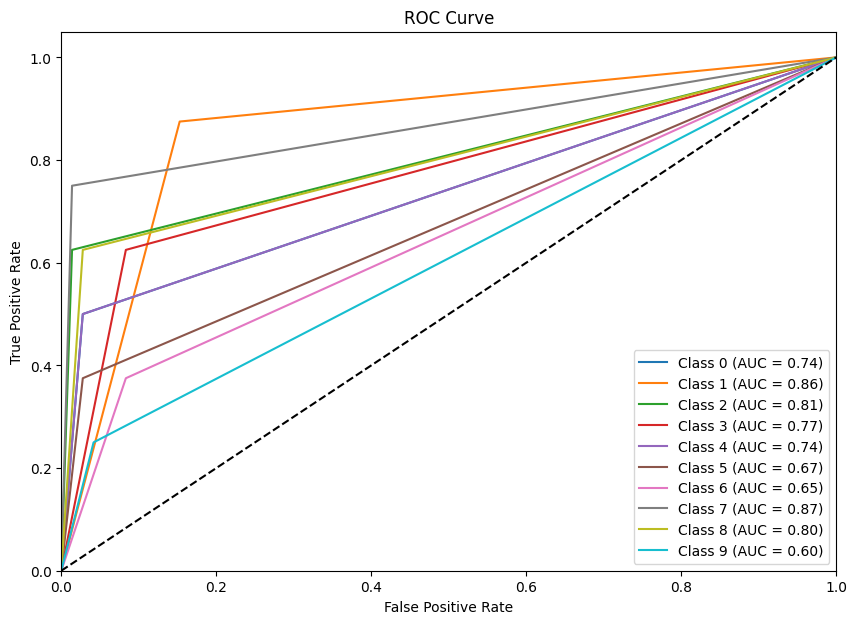

In [109]:

test_loader = custom_data_module.test_dataloader()
# Assuming you have `model`, `test_loader`, and `device` defined
auc_roc_curve(model, test_loader, device)


In [110]:
# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())

# Count the number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count the number of non-trainable parameters
non_trainable_params = total_params - trainable_params

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

Total parameters: 616074
Trainable parameters: 616074
Non-trainable parameters: 0


Heads in Attention block = 4

In [111]:
# Initialize the model
num_classes = 10
num_heads = 4 # You can change the number of heads as needed
model = AudioClassifierRegularized(num_classes, num_heads).to(device)

In [112]:
import wandb

model = SimpleCnn(num_classes = 10 , dropout_rate=0.5, weight_decay=0.001).to(device)

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.95)  # Use momentum here

val_loader = custom_data_module.val_dataloader()

# Define the early stopping parameters
patience = 25
best_val_loss = float('inf')
early_stop_counter = 0


wandb.init(
    project="Audio_Transformer", 
    config={
    "learning_rate": 0.0001,
    "architecture": "SimpleCnn",
    "dataset": "ESC",
    "epochs": 100,
    })

train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

num_epochs = 100

for epoch in range(num_epochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    model.train()
    for i, data in enumerate(custom_data_module.train_dataloader(), 0):
        inputs, labels = data

        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate and store training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_list.append(train_accuracy)

    # Calculate and store average training loss
    train_loss_list.append(train_loss / len(custom_data_module.train_dataloader()))

    wandb.log({"train_acc": train_accuracy, "train_loss": train_loss})

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data in custom_data_module.val_dataloader():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate and store validation accuracy
    val_accuracy = correct_val / total_val
    val_accuracy_list.append(val_accuracy)

    # Calculate and store average validation loss
    val_loss /= len(custom_data_module.val_dataloader())
    val_loss_list.append(val_loss)
    wandb.log({"val_acc": val_accuracy, "val_loss": val_loss})
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping!")
        break
wandb.finish()
print('Training Done')

Epoch 1/100, Training Accuracy: 0.2375, Validation Accuracy: 0.2125, Validation Loss: 2.368025168776512
Epoch 2/100, Training Accuracy: 0.3875, Validation Accuracy: 0.35, Validation Loss: 2.369510228186846
Epoch 3/100, Training Accuracy: 0.48333333333333334, Validation Accuracy: 0.325, Validation Loss: 2.3951168239116667
Epoch 4/100, Training Accuracy: 0.5708333333333333, Validation Accuracy: 0.45, Validation Loss: 1.6165687188506126
Epoch 5/100, Training Accuracy: 0.6291666666666667, Validation Accuracy: 0.4625, Validation Loss: 2.028031072020531
Epoch 6/100, Training Accuracy: 0.6583333333333333, Validation Accuracy: 0.4, Validation Loss: 1.9882723644375802
Epoch 7/100, Training Accuracy: 0.7291666666666666, Validation Accuracy: 0.5125, Validation Loss: 1.5696511268615723
Epoch 8/100, Training Accuracy: 0.7708333333333334, Validation Accuracy: 0.4625, Validation Loss: 1.6598337769508362
Epoch 9/100, Training Accuracy: 0.8041666666666667, Validation Accuracy: 0.525, Validation Loss: 1

Training Done


In [113]:
test_loss, test_accuracy = evaluate_test(model, custom_data_module.test_dataloader(), criterion, device)
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')

Test Accuracy: 0.45, Test Loss: 2.014606793721517


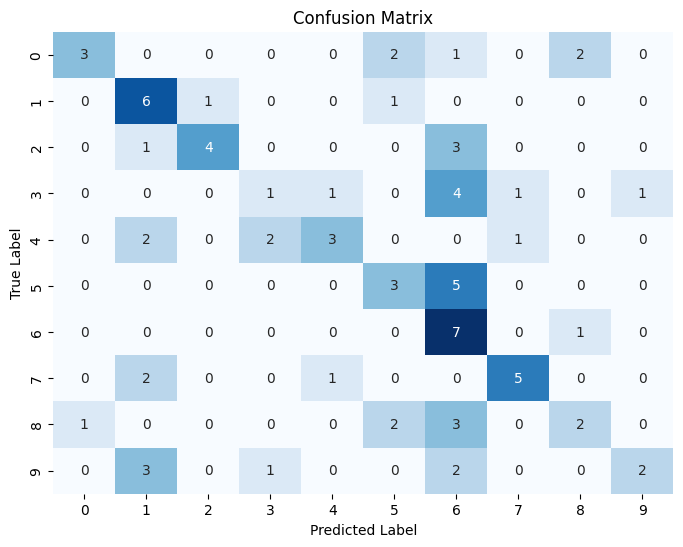

              precision    recall  f1-score   support

           0       0.75      0.38      0.50         8
           1       0.43      0.75      0.55         8
           2       0.80      0.50      0.62         8
           3       0.25      0.12      0.17         8
           4       0.60      0.38      0.46         8
           5       0.38      0.38      0.38         8
           6       0.28      0.88      0.42         8
           7       0.71      0.62      0.67         8
           8       0.40      0.25      0.31         8
           9       0.67      0.25      0.36         8

    accuracy                           0.45        80
   macro avg       0.53      0.45      0.44        80
weighted avg       0.53      0.45      0.44        80



In [114]:
acc, cm, report, y_true, y_pred = evaluate_model(model, custom_data_module.test_dataloader(), device)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# Print classification report with zero_division=1
print(classification_report(y_true, y_pred, zero_division=1))


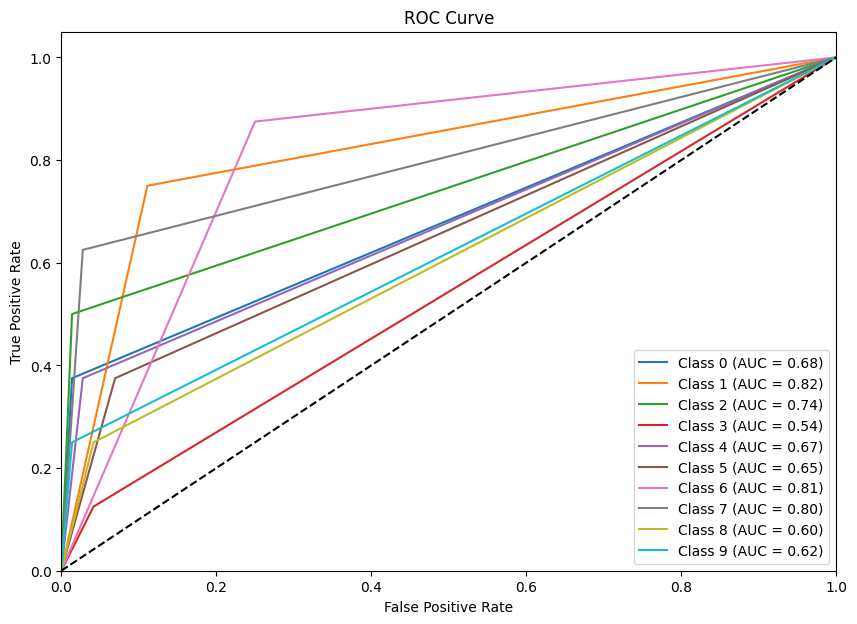

In [115]:

test_loader = custom_data_module.test_dataloader()
# Assuming you have `model`, `test_loader`, and `device` defined
auc_roc_curve(model, test_loader, device)

In [116]:
# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())

# Count the number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count the number of non-trainable parameters
non_trainable_params = total_params - trainable_params

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

Total parameters: 616074
Trainable parameters: 616074
Non-trainable parameters: 0


k = 3 Validation Fold

In [119]:
k = 3 
custom_data_module = setup_custom_data_module(k)

100%|██████████| 80/80 [00:00<00:00, 8339.41it/s]


100%|██████████| 80/80 [00:00<00:00, 6323.98it/s]


Heads in Attention block = 1

In [120]:
# Initialize the model
num_classes = 10
num_heads = 1 # You can change the number of heads as needed
model = AudioClassifierRegularized(num_classes, num_heads).to(device)

In [121]:
import wandb

model = SimpleCnn(num_classes = 10 , dropout_rate=0.5, weight_decay=0.001).to(device)

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.95)  # Use momentum here

val_loader = custom_data_module.val_dataloader()

# Define the early stopping parameters
patience = 25
best_val_loss = float('inf')
early_stop_counter = 0


wandb.init(
    project="Audio_Transformer", 
    config={
    "learning_rate": 0.0001,
    "architecture": "SimpleCnn",
    "dataset": "ESC",
    "epochs": 100,
    })

train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

num_epochs = 100

for epoch in range(num_epochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    model.train()
    for i, data in enumerate(custom_data_module.train_dataloader(), 0):
        inputs, labels = data

        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate and store training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_list.append(train_accuracy)

    # Calculate and store average training loss
    train_loss_list.append(train_loss / len(custom_data_module.train_dataloader()))

    wandb.log({"train_acc": train_accuracy, "train_loss": train_loss})

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data in custom_data_module.val_dataloader():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate and store validation accuracy
    val_accuracy = correct_val / total_val
    val_accuracy_list.append(val_accuracy)

    # Calculate and store average validation loss
    val_loss /= len(custom_data_module.val_dataloader())
    val_loss_list.append(val_loss)
    wandb.log({"val_acc": val_accuracy, "val_loss": val_loss})
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping!")
        break
wandb.finish()
print('Training Done')



Epoch 1/100, Training Accuracy: 0.22916666666666666, Validation Accuracy: 0.1375, Validation Loss: 2.4923755526542664
Epoch 2/100, Training Accuracy: 0.45416666666666666, Validation Accuracy: 0.3875, Validation Loss: 1.767796903848648
Epoch 3/100, Training Accuracy: 0.5375, Validation Accuracy: 0.5, Validation Loss: 1.614410263299942
Epoch 4/100, Training Accuracy: 0.6041666666666666, Validation Accuracy: 0.425, Validation Loss: 2.0082616440951826
Epoch 5/100, Training Accuracy: 0.5916666666666667, Validation Accuracy: 0.4125, Validation Loss: 2.6676126742735504
Epoch 6/100, Training Accuracy: 0.6791666666666667, Validation Accuracy: 0.4375, Validation Loss: 2.566590105742216
Epoch 7/100, Training Accuracy: 0.6958333333333333, Validation Accuracy: 0.475, Validation Loss: 1.8511496698483825
Epoch 8/100, Training Accuracy: 0.8208333333333333, Validation Accuracy: 0.475, Validation Loss: 1.9788159430027008
Epoch 9/100, Training Accuracy: 0.8083333333333333, Validation Accuracy: 0.5125, Va

Training Done


In [122]:
test_loss, test_accuracy = evaluate_test(model, custom_data_module.test_dataloader(), criterion, device)
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')

Test Accuracy: 0.4625, Test Loss: 1.793867031733195


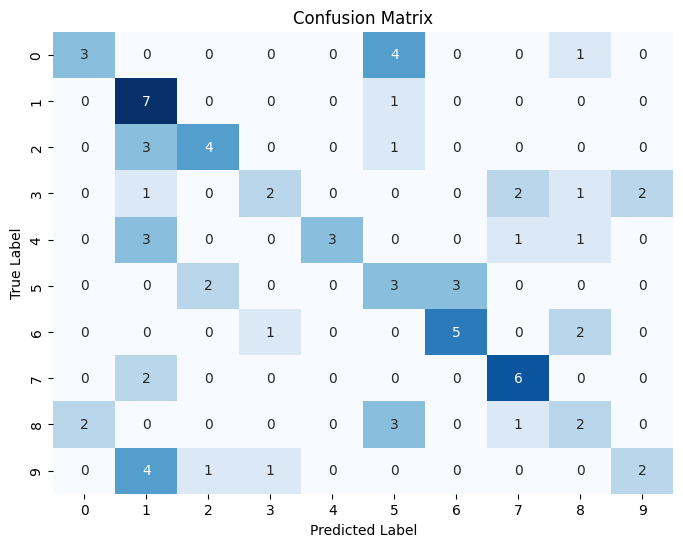

              precision    recall  f1-score   support

           0       0.60      0.38      0.46         8
           1       0.35      0.88      0.50         8
           2       0.57      0.50      0.53         8
           3       0.50      0.25      0.33         8
           4       1.00      0.38      0.55         8
           5       0.25      0.38      0.30         8
           6       0.62      0.62      0.62         8
           7       0.60      0.75      0.67         8
           8       0.29      0.25      0.27         8
           9       0.50      0.25      0.33         8

    accuracy                           0.46        80
   macro avg       0.53      0.46      0.46        80
weighted avg       0.53      0.46      0.46        80



In [123]:
acc, cm, report, y_true, y_pred = evaluate_model(model, custom_data_module.test_dataloader(), device)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# Print classification report with zero_division=1
print(classification_report(y_true, y_pred, zero_division=1))

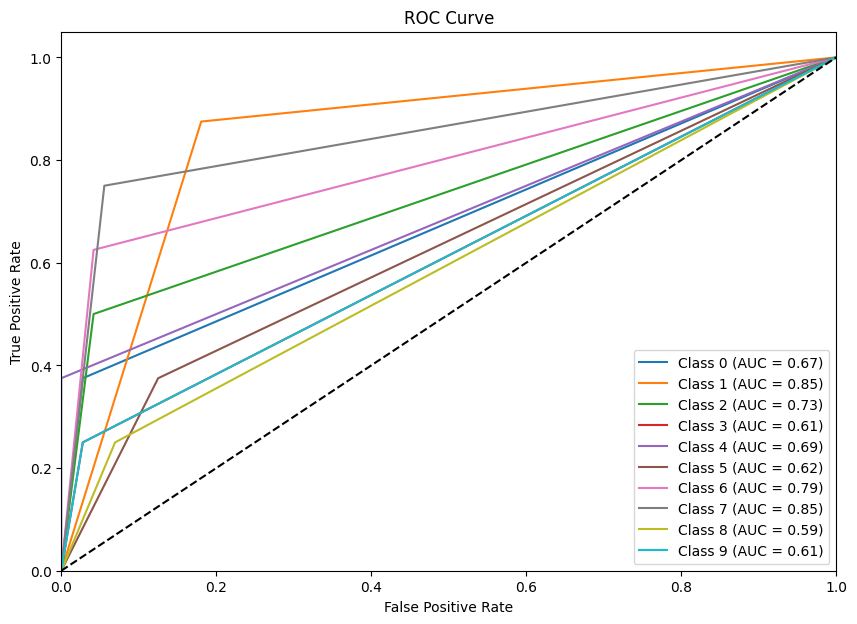

In [124]:
test_loader = custom_data_module.test_dataloader()
# Assuming you have `model`, `test_loader`, and `device` defined
auc_roc_curve(model, test_loader, device)

In [125]:
# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())

# Count the number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count the number of non-trainable parameters
non_trainable_params = total_params - trainable_params

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

Total parameters: 616074
Trainable parameters: 616074
Non-trainable parameters: 0


Heads in Attention block = 2

In [126]:
# Initialize the model
num_classes = 10
num_heads = 2 # You can change the number of heads as needed
model = AudioClassifierRegularized(num_classes, num_heads).to(device)


In [127]:
import wandb

model = SimpleCnn(num_classes = 10 , dropout_rate=0.5, weight_decay=0.001).to(device)

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.95)  # Use momentum here

val_loader = custom_data_module.val_dataloader()

# Define the early stopping parameters
patience = 25
best_val_loss = float('inf')
early_stop_counter = 0


wandb.init(
    project="Audio_Transformer", 
    config={
    "learning_rate": 0.0001,
    "architecture": "SimpleCnn",
    "dataset": "ESC",
    "epochs": 100,
    })

train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

num_epochs = 100

for epoch in range(num_epochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    model.train()
    for i, data in enumerate(custom_data_module.train_dataloader(), 0):
        inputs, labels = data

        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate and store training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_list.append(train_accuracy)

    # Calculate and store average training loss
    train_loss_list.append(train_loss / len(custom_data_module.train_dataloader()))

    wandb.log({"train_acc": train_accuracy, "train_loss": train_loss})

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data in custom_data_module.val_dataloader():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate and store validation accuracy
    val_accuracy = correct_val / total_val
    val_accuracy_list.append(val_accuracy)

    # Calculate and store average validation loss
    val_loss /= len(custom_data_module.val_dataloader())
    val_loss_list.append(val_loss)
    wandb.log({"val_acc": val_accuracy, "val_loss": val_loss})
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping!")
        break
wandb.finish()
print('Training Done')

Epoch 1/100, Training Accuracy: 0.20833333333333334, Validation Accuracy: 0.2375, Validation Loss: 2.689058232307434
Epoch 2/100, Training Accuracy: 0.3416666666666667, Validation Accuracy: 0.325, Validation Loss: 2.5379572972655295
Epoch 3/100, Training Accuracy: 0.5125, Validation Accuracy: 0.3625, Validation Loss: 2.859354069828987
Epoch 4/100, Training Accuracy: 0.5166666666666667, Validation Accuracy: 0.4875, Validation Loss: 2.0025621257722377
Epoch 5/100, Training Accuracy: 0.6291666666666667, Validation Accuracy: 0.4375, Validation Loss: 1.7803254928439856
Epoch 6/100, Training Accuracy: 0.65, Validation Accuracy: 0.45, Validation Loss: 1.7397025123238563
Epoch 7/100, Training Accuracy: 0.7, Validation Accuracy: 0.4375, Validation Loss: 2.4467044746503235
Epoch 8/100, Training Accuracy: 0.7041666666666667, Validation Accuracy: 0.425, Validation Loss: 1.9504863500595093
Epoch 9/100, Training Accuracy: 0.7541666666666667, Validation Accuracy: 0.4625, Validation Loss: 1.6659080967

Training Done


In [128]:
test_loss, test_accuracy = evaluate_test(model, custom_data_module.test_dataloader(), criterion, device)
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')

Test Accuracy: 0.5125, Test Loss: 1.6866341829299927


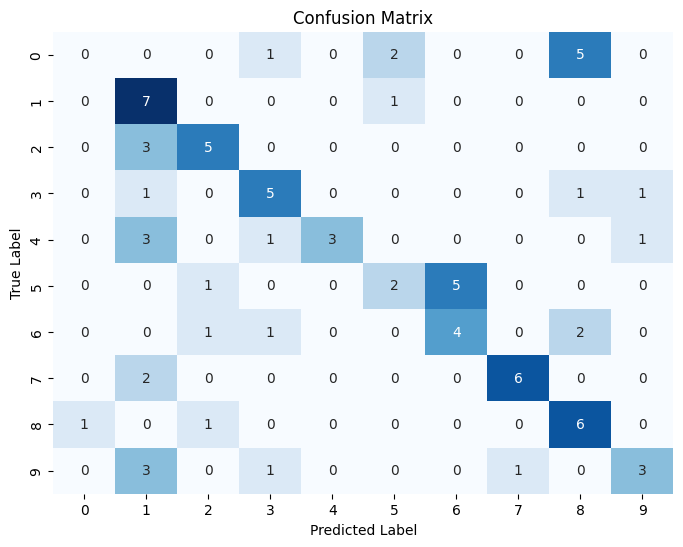

              precision    recall  f1-score   support

           0       0.00      0.00      1.00         8
           1       0.37      0.88      0.52         8
           2       0.62      0.62      0.62         8
           3       0.56      0.62      0.59         8
           4       1.00      0.38      0.55         8
           5       0.40      0.25      0.31         8
           6       0.44      0.50      0.47         8
           7       0.86      0.75      0.80         8
           8       0.43      0.75      0.55         8
           9       0.60      0.38      0.46         8

    accuracy                           0.51        80
   macro avg       0.53      0.51      0.59        80
weighted avg       0.53      0.51      0.59        80



In [129]:
acc, cm, report, y_true, y_pred = evaluate_model(model, custom_data_module.test_dataloader(), device)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# Print classification report with zero_division=1
print(classification_report(y_true, y_pred, zero_division=1))

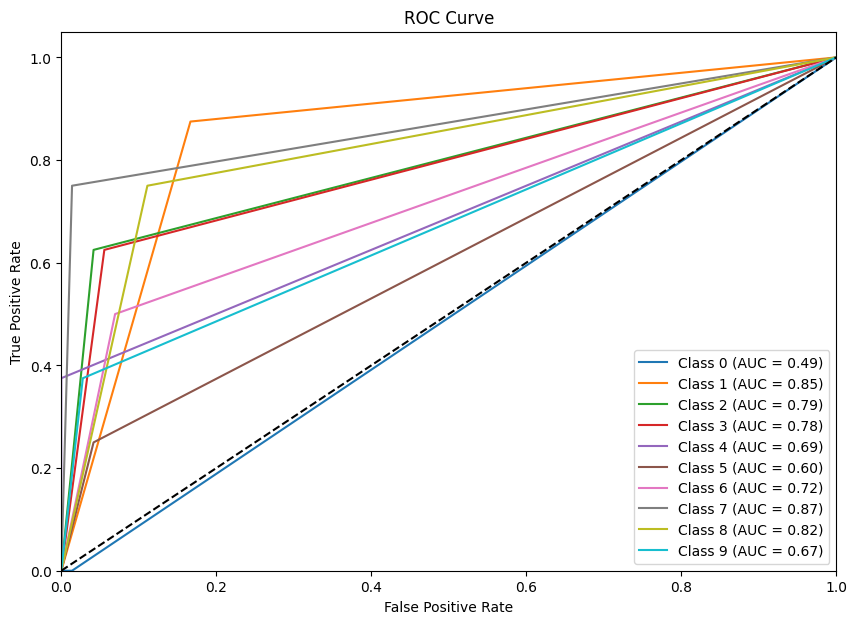

In [130]:
test_loader = custom_data_module.test_dataloader()
# Assuming you have `model`, `test_loader`, and `device` defined
auc_roc_curve(model, test_loader, device)

In [131]:
# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())

# Count the number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count the number of non-trainable parameters
non_trainable_params = total_params - trainable_params

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

Total parameters: 616074
Trainable parameters: 616074
Non-trainable parameters: 0


Heads in Attention block = 4

In [132]:
# Initialize the model
num_classes = 10
num_heads = 4 # You can change the number of heads as needed
model = AudioClassifierRegularized(num_classes, num_heads).to(device)

In [133]:
import wandb

model = SimpleCnn(num_classes = 10 , dropout_rate=0.5, weight_decay=0.001).to(device)

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.95)  # Use momentum here

val_loader = custom_data_module.val_dataloader()

# Define the early stopping parameters
patience = 25
best_val_loss = float('inf')
early_stop_counter = 0


wandb.init(
    project="Audio_Transformer", 
    config={
    "learning_rate": 0.0001,
    "architecture": "SimpleCnn",
    "dataset": "ESC",
    "epochs": 100,
    })

train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

num_epochs = 100

for epoch in range(num_epochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    model.train()
    for i, data in enumerate(custom_data_module.train_dataloader(), 0):
        inputs, labels = data

        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate and store training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_list.append(train_accuracy)

    # Calculate and store average training loss
    train_loss_list.append(train_loss / len(custom_data_module.train_dataloader()))

    wandb.log({"train_acc": train_accuracy, "train_loss": train_loss})

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data in custom_data_module.val_dataloader():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate and store validation accuracy
    val_accuracy = correct_val / total_val
    val_accuracy_list.append(val_accuracy)

    # Calculate and store average validation loss
    val_loss /= len(custom_data_module.val_dataloader())
    val_loss_list.append(val_loss)
    wandb.log({"val_acc": val_accuracy, "val_loss": val_loss})
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping!")
        break
wandb.finish()
print('Training Done')

Epoch 1/100, Training Accuracy: 0.19166666666666668, Validation Accuracy: 0.2, Validation Loss: 2.3226562678813933
Epoch 2/100, Training Accuracy: 0.4041666666666667, Validation Accuracy: 0.475, Validation Loss: 1.63674788326025
Epoch 3/100, Training Accuracy: 0.4666666666666667, Validation Accuracy: 0.3375, Validation Loss: 2.089906433224678
Epoch 4/100, Training Accuracy: 0.5375, Validation Accuracy: 0.4375, Validation Loss: 1.7144829742610455
Epoch 5/100, Training Accuracy: 0.5833333333333334, Validation Accuracy: 0.4125, Validation Loss: 1.7470092162489892
Epoch 6/100, Training Accuracy: 0.6708333333333333, Validation Accuracy: 0.45, Validation Loss: 1.8356332369148731
Epoch 7/100, Training Accuracy: 0.65, Validation Accuracy: 0.5375, Validation Loss: 1.5628333158791066
Epoch 8/100, Training Accuracy: 0.7083333333333334, Validation Accuracy: 0.5125, Validation Loss: 1.8181606508791446
Epoch 9/100, Training Accuracy: 0.7708333333333334, Validation Accuracy: 0.5125, Validation Loss: 

Training Done


In [134]:
test_loss, test_accuracy = evaluate_test(model, custom_data_module.test_dataloader(), criterion, device)
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')

Test Accuracy: 0.4875, Test Loss: 1.9807106653849285


/home/user/anaconda3/envs/dl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/anaconda3/envs/dl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/anaconda3/envs/dl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


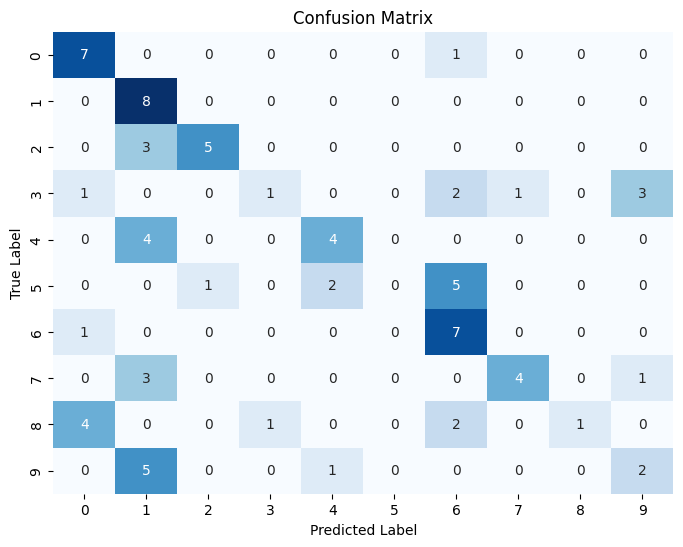

              precision    recall  f1-score   support

           0       0.54      0.88      0.67         8
           1       0.35      1.00      0.52         8
           2       0.83      0.62      0.71         8
           3       0.50      0.12      0.20         8
           4       0.57      0.50      0.53         8
           5       1.00      0.00      0.00         8
           6       0.41      0.88      0.56         8
           7       0.80      0.50      0.62         8
           8       1.00      0.12      0.22         8
           9       0.33      0.25      0.29         8

    accuracy                           0.49        80
   macro avg       0.63      0.49      0.43        80
weighted avg       0.63      0.49      0.43        80



In [135]:
acc, cm, report, y_true, y_pred = evaluate_model(model, custom_data_module.test_dataloader(), device)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# Print classification report with zero_division=1
print(classification_report(y_true, y_pred, zero_division=1))

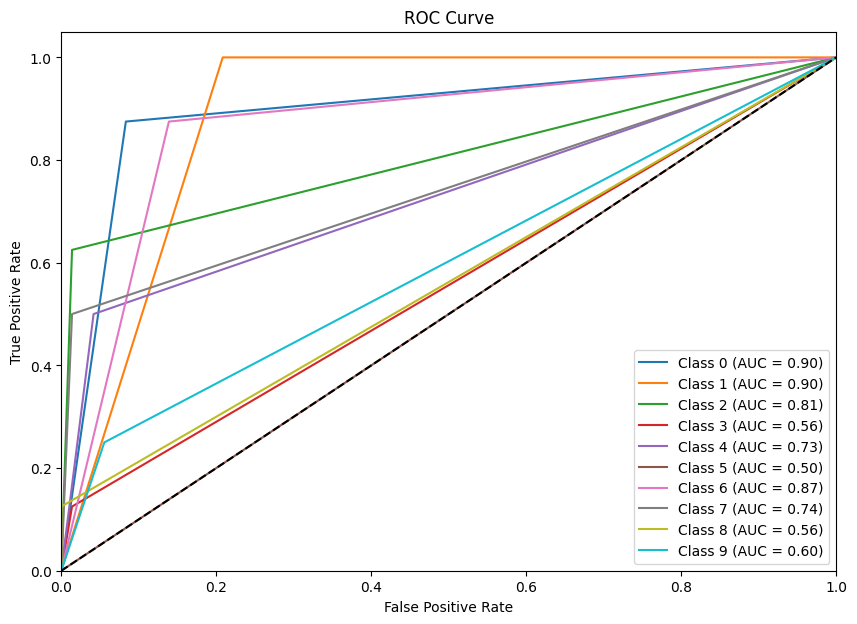

In [136]:
test_loader = custom_data_module.test_dataloader()
# Assuming you have `model`, `test_loader`, and `device` defined
auc_roc_curve(model, test_loader, device)


In [137]:
# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())

# Count the number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count the number of non-trainable parameters
non_trainable_params = total_params - trainable_params

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

Total parameters: 616074
Trainable parameters: 616074
Non-trainable parameters: 0


k = 4 Validation Fold

In [138]:
k = 4 
custom_data_module = setup_custom_data_module(k)

100%|██████████| 80/80 [00:00<00:00, 6198.17it/s]


Heads in Attention block = 1

In [139]:
# Initialize the model
num_classes = 10
num_heads = 1 # You can change the number of heads as needed
model = AudioClassifierRegularized(num_classes, num_heads).to(device)

In [140]:
import wandb

model = SimpleCnn(num_classes = 10 , dropout_rate=0.5, weight_decay=0.001).to(device)

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.95)  # Use momentum here

val_loader = custom_data_module.val_dataloader()

# Define the early stopping parameters
patience = 25
best_val_loss = float('inf')
early_stop_counter = 0


wandb.init(
    project="Audio_Transformer", 
    config={
    "learning_rate": 0.0001,
    "architecture": "SimpleCnn",
    "dataset": "ESC",
    "epochs": 100,
    })

train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

num_epochs = 100

for epoch in range(num_epochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    model.train()
    for i, data in enumerate(custom_data_module.train_dataloader(), 0):
        inputs, labels = data

        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate and store training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_list.append(train_accuracy)

    # Calculate and store average training loss
    train_loss_list.append(train_loss / len(custom_data_module.train_dataloader()))

    wandb.log({"train_acc": train_accuracy, "train_loss": train_loss})

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data in custom_data_module.val_dataloader():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate and store validation accuracy
    val_accuracy = correct_val / total_val
    val_accuracy_list.append(val_accuracy)

    # Calculate and store average validation loss
    val_loss /= len(custom_data_module.val_dataloader())
    val_loss_list.append(val_loss)
    wandb.log({"val_acc": val_accuracy, "val_loss": val_loss})
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping!")
        break
wandb.finish()
print('Training Done')

Epoch 1/100, Training Accuracy: 0.175, Validation Accuracy: 0.125, Validation Loss: 2.9503235459327697
Epoch 2/100, Training Accuracy: 0.3958333333333333, Validation Accuracy: 0.4, Validation Loss: 1.640959659218788
Epoch 3/100, Training Accuracy: 0.42916666666666664, Validation Accuracy: 0.5375, Validation Loss: 1.7482147634029388
Epoch 4/100, Training Accuracy: 0.5291666666666667, Validation Accuracy: 0.5125, Validation Loss: 1.4608861654996872
Epoch 5/100, Training Accuracy: 0.6666666666666666, Validation Accuracy: 0.525, Validation Loss: 1.5523425042629242
Epoch 6/100, Training Accuracy: 0.6166666666666667, Validation Accuracy: 0.475, Validation Loss: 1.6110082179307939
Epoch 7/100, Training Accuracy: 0.6416666666666667, Validation Accuracy: 0.4125, Validation Loss: 1.9487933695316315
Epoch 8/100, Training Accuracy: 0.65, Validation Accuracy: 0.45, Validation Loss: 1.7164621621370315
Epoch 9/100, Training Accuracy: 0.6583333333333333, Validation Accuracy: 0.5375, Validation Loss: 1

Training Done


In [141]:
test_loss, test_accuracy = evaluate_test(model, custom_data_module.test_dataloader(), criterion, device)
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')


Test Accuracy: 0.5, Test Loss: 1.50343519449234


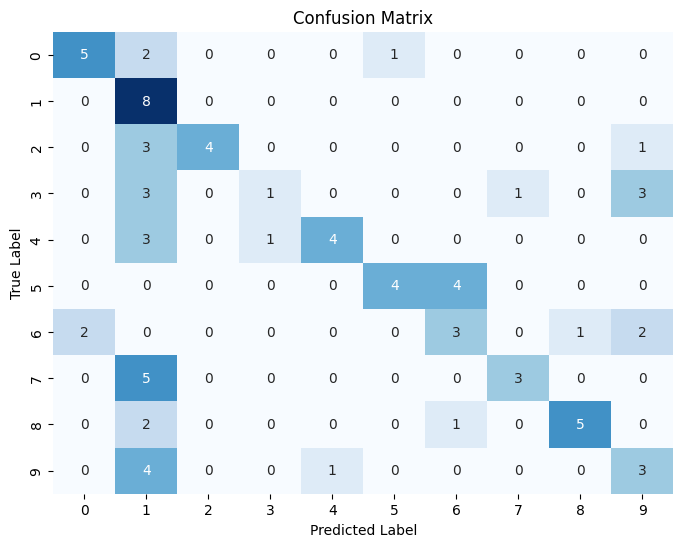

              precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.27      1.00      0.42         8
           2       1.00      0.50      0.67         8
           3       0.50      0.12      0.20         8
           4       0.80      0.50      0.62         8
           5       0.80      0.50      0.62         8
           6       0.38      0.38      0.38         8
           7       0.75      0.38      0.50         8
           8       0.83      0.62      0.71         8
           9       0.33      0.38      0.35         8

    accuracy                           0.50        80
   macro avg       0.64      0.50      0.51        80
weighted avg       0.64      0.50      0.51        80



In [142]:
acc, cm, report, y_true, y_pred = evaluate_model(model, custom_data_module.test_dataloader(), device)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# Print classification report with zero_division=1
print(classification_report(y_true, y_pred, zero_division=1))

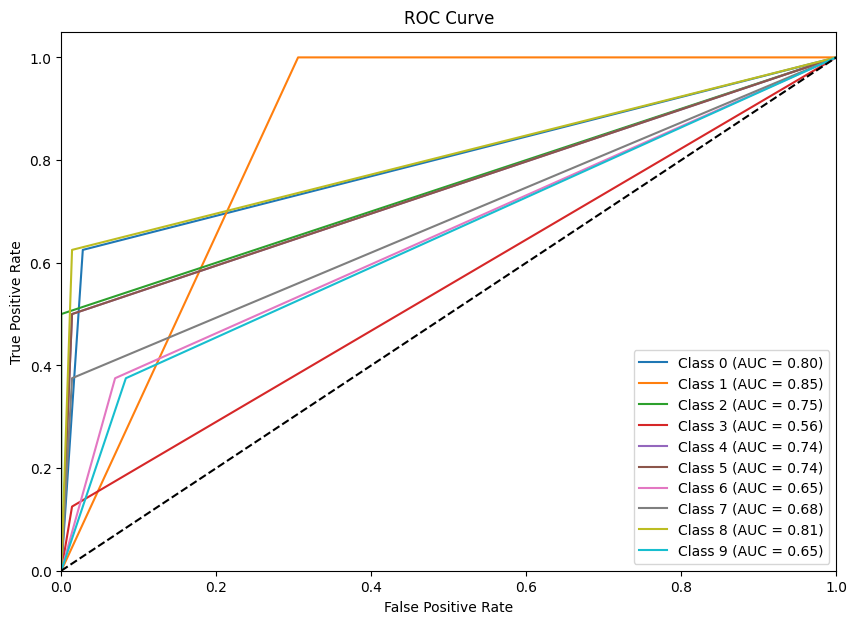

In [143]:

test_loader = custom_data_module.test_dataloader()
# Assuming you have `model`, `test_loader`, and `device` defined
auc_roc_curve(model, test_loader, device)


In [144]:
# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())

# Count the number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count the number of non-trainable parameters
non_trainable_params = total_params - trainable_params

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")


Total parameters: 616074
Trainable parameters: 616074
Non-trainable parameters: 0


Heads in Attention block = 2

In [145]:
# Initialize the model
num_classes = 10
num_heads = 2 # You can change the number of heads as needed
model = AudioClassifierRegularized(num_classes, num_heads).to(device)

In [146]:
import wandb

model = SimpleCnn(num_classes = 10 , dropout_rate=0.5, weight_decay=0.001).to(device)

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.95)  # Use momentum here

val_loader = custom_data_module.val_dataloader()

# Define the early stopping parameters
patience = 25
best_val_loss = float('inf')
early_stop_counter = 0


wandb.init(
    project="Audio_Transformer", 
    config={
    "learning_rate": 0.0001,
    "architecture": "SimpleCnn",
    "dataset": "ESC",
    "epochs": 100,
    })

train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

num_epochs = 100

for epoch in range(num_epochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    model.train()
    for i, data in enumerate(custom_data_module.train_dataloader(), 0):
        inputs, labels = data

        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate and store training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_list.append(train_accuracy)

    # Calculate and store average training loss
    train_loss_list.append(train_loss / len(custom_data_module.train_dataloader()))

    wandb.log({"train_acc": train_accuracy, "train_loss": train_loss})

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data in custom_data_module.val_dataloader():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate and store validation accuracy
    val_accuracy = correct_val / total_val
    val_accuracy_list.append(val_accuracy)

    # Calculate and store average validation loss
    val_loss /= len(custom_data_module.val_dataloader())
    val_loss_list.append(val_loss)
    wandb.log({"val_acc": val_accuracy, "val_loss": val_loss})
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping!")
        break
wandb.finish()
print('Training Done')

Epoch 1/100, Training Accuracy: 0.20833333333333334, Validation Accuracy: 0.15, Validation Loss: 2.504117751121521
Epoch 2/100, Training Accuracy: 0.4125, Validation Accuracy: 0.3875, Validation Loss: 1.8490710854530334
Epoch 3/100, Training Accuracy: 0.5125, Validation Accuracy: 0.4375, Validation Loss: 1.6472214512526988
Epoch 4/100, Training Accuracy: 0.5333333333333333, Validation Accuracy: 0.55, Validation Loss: 1.3957338482141495
Epoch 5/100, Training Accuracy: 0.6541666666666667, Validation Accuracy: 0.475, Validation Loss: 1.4546303063631059
Epoch 6/100, Training Accuracy: 0.6333333333333333, Validation Accuracy: 0.6125, Validation Loss: 1.2556326776742934
Epoch 7/100, Training Accuracy: 0.6041666666666666, Validation Accuracy: 0.4875, Validation Loss: 1.519422347843647
Epoch 8/100, Training Accuracy: 0.675, Validation Accuracy: 0.525, Validation Loss: 1.6946743108332156
Epoch 9/100, Training Accuracy: 0.7208333333333333, Validation Accuracy: 0.45, Validation Loss: 1.5482731044

Training Done


In [147]:
test_loss, test_accuracy = evaluate_test(model, custom_data_module.test_dataloader(), criterion, device)
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')


Test Accuracy: 0.6, Test Loss: 1.513881266117096


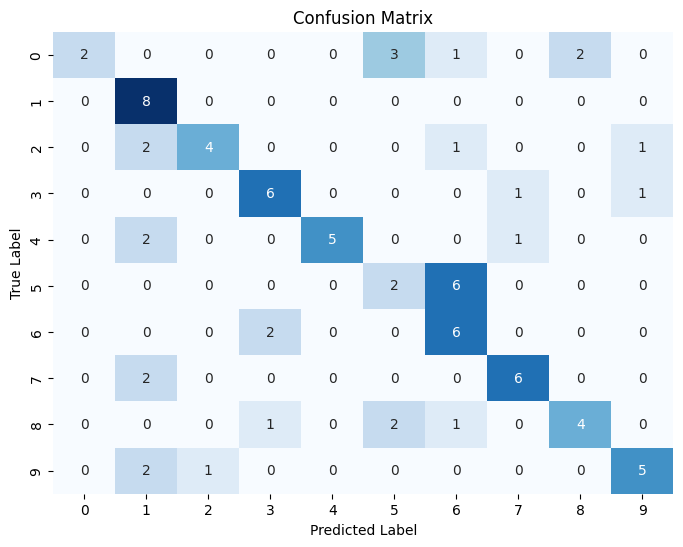

              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.50      1.00      0.67         8
           2       0.80      0.50      0.62         8
           3       0.67      0.75      0.71         8
           4       1.00      0.62      0.77         8
           5       0.29      0.25      0.27         8
           6       0.40      0.75      0.52         8
           7       0.75      0.75      0.75         8
           8       0.67      0.50      0.57         8
           9       0.71      0.62      0.67         8

    accuracy                           0.60        80
   macro avg       0.68      0.60      0.59        80
weighted avg       0.68      0.60      0.59        80



In [148]:
acc, cm, report, y_true, y_pred = evaluate_model(model, custom_data_module.test_dataloader(), device)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# Print classification report with zero_division=1
print(classification_report(y_true, y_pred, zero_division=1))


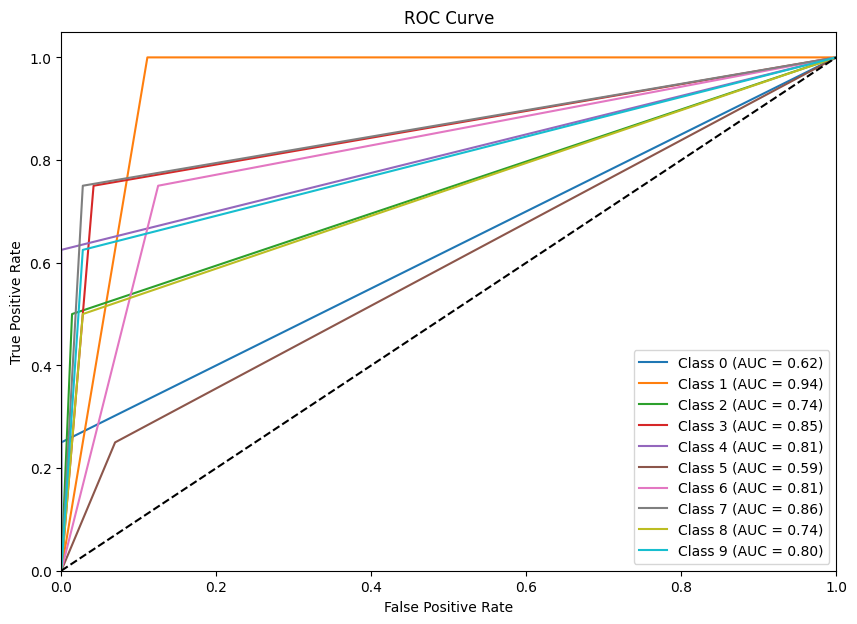

In [149]:
test_loader = custom_data_module.test_dataloader()
# Assuming you have `model`, `test_loader`, and `device` defined
auc_roc_curve(model, test_loader, device)

In [150]:
# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())

# Count the number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count the number of non-trainable parameters
non_trainable_params = total_params - trainable_params

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")


Total parameters: 616074
Trainable parameters: 616074
Non-trainable parameters: 0


Heads in Attention block = 4

In [151]:
# Initialize the model
num_classes = 10
num_heads = 4 # You can change the number of heads as needed
model = AudioClassifierRegularized(num_classes, num_heads).to(device)

In [152]:
import wandb

model = SimpleCnn(num_classes = 10 , dropout_rate=0.5, weight_decay=0.001).to(device)

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.95)  # Use momentum here

val_loader = custom_data_module.val_dataloader()

# Define the early stopping parameters
patience = 25
best_val_loss = float('inf')
early_stop_counter = 0


wandb.init(
    project="Audio_Transformer", 
    config={
    "learning_rate": 0.0001,
    "architecture": "SimpleCnn",
    "dataset": "ESC",
    "epochs": 100,
    })

train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

num_epochs = 100

for epoch in range(num_epochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    model.train()
    for i, data in enumerate(custom_data_module.train_dataloader(), 0):
        inputs, labels = data

        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate and store training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_list.append(train_accuracy)

    # Calculate and store average training loss
    train_loss_list.append(train_loss / len(custom_data_module.train_dataloader()))

    wandb.log({"train_acc": train_accuracy, "train_loss": train_loss})

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data in custom_data_module.val_dataloader():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate and store validation accuracy
    val_accuracy = correct_val / total_val
    val_accuracy_list.append(val_accuracy)

    # Calculate and store average validation loss
    val_loss /= len(custom_data_module.val_dataloader())
    val_loss_list.append(val_loss)
    wandb.log({"val_acc": val_accuracy, "val_loss": val_loss})
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping!")
        break
wandb.finish()
print('Training Done')

Epoch 1/100, Training Accuracy: 0.2125, Validation Accuracy: 0.125, Validation Loss: 2.801851177215576
Epoch 2/100, Training Accuracy: 0.44583333333333336, Validation Accuracy: 0.425, Validation Loss: 1.8407867938280105
Epoch 3/100, Training Accuracy: 0.45416666666666666, Validation Accuracy: 0.45, Validation Loss: 1.7042937219142913
Epoch 4/100, Training Accuracy: 0.525, Validation Accuracy: 0.5375, Validation Loss: 1.9148770451545716
Epoch 5/100, Training Accuracy: 0.5916666666666667, Validation Accuracy: 0.4375, Validation Loss: 1.546923492848873
Epoch 6/100, Training Accuracy: 0.6708333333333333, Validation Accuracy: 0.6125, Validation Loss: 1.245917658507824
Epoch 7/100, Training Accuracy: 0.7166666666666667, Validation Accuracy: 0.525, Validation Loss: 1.4699634313583374
Epoch 8/100, Training Accuracy: 0.7125, Validation Accuracy: 0.5375, Validation Loss: 1.34217017441988
Epoch 9/100, Training Accuracy: 0.7333333333333333, Validation Accuracy: 0.6125, Validation Loss: 1.244557457

Training Done


In [153]:
test_loss, test_accuracy = evaluate_test(model, custom_data_module.test_dataloader(), criterion, device)
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')

Test Accuracy: 0.4375, Test Loss: 1.6181914409001668


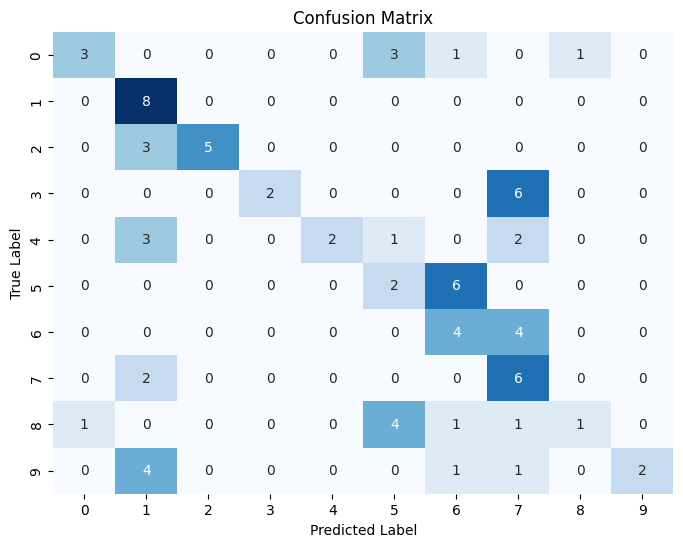

              precision    recall  f1-score   support

           0       0.75      0.38      0.50         8
           1       0.40      1.00      0.57         8
           2       1.00      0.62      0.77         8
           3       1.00      0.25      0.40         8
           4       1.00      0.25      0.40         8
           5       0.20      0.25      0.22         8
           6       0.31      0.50      0.38         8
           7       0.30      0.75      0.43         8
           8       0.50      0.12      0.20         8
           9       1.00      0.25      0.40         8

    accuracy                           0.44        80
   macro avg       0.65      0.44      0.43        80
weighted avg       0.65      0.44      0.43        80



In [154]:
acc, cm, report, y_true, y_pred = evaluate_model(model, custom_data_module.test_dataloader(), device)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# Print classification report with zero_division=1
print(classification_report(y_true, y_pred, zero_division=1))

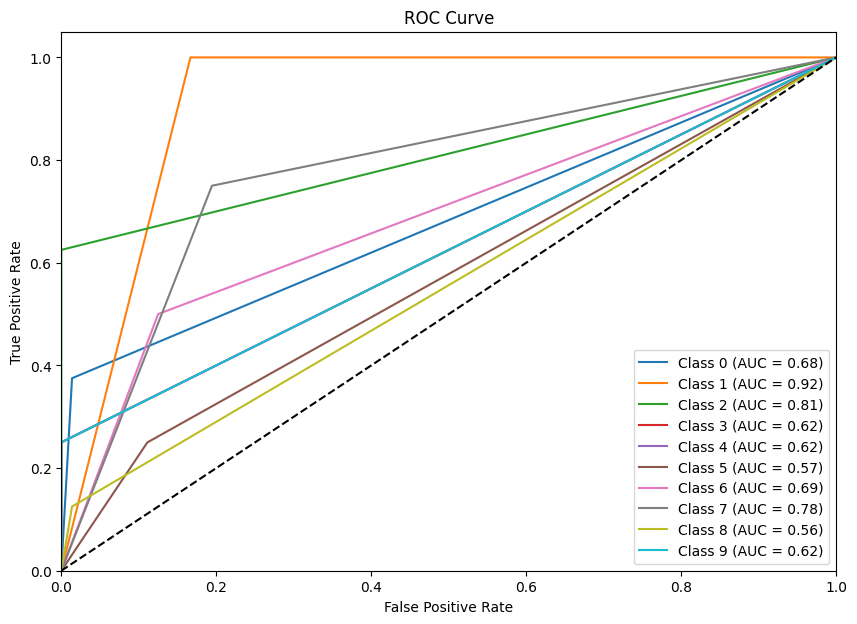

In [155]:
test_loader = custom_data_module.test_dataloader()
# Assuming you have `model`, `test_loader`, and `device` defined
auc_roc_curve(model, test_loader, device)

In [156]:
# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())

# Count the number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count the number of non-trainable parameters
non_trainable_params = total_params - trainable_params

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

Total parameters: 616074
Trainable parameters: 616074
Non-trainable parameters: 0


k = 5 Validation Fold

In [158]:
k = 5  
custom_data_module = setup_custom_data_module(k)

100%|██████████| 80/80 [00:00<00:00, 8298.16it/s]


Heads in Attention block = 1

In [159]:
# Initialize the model
num_classes = 10
num_heads = 1 # You can change the number of heads as needed
model = AudioClassifierRegularized(num_classes, num_heads).to(device)

In [160]:
import wandb

model = SimpleCnn(num_classes = 10 , dropout_rate=0.5, weight_decay=0.001).to(device)

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.95)  # Use momentum here

val_loader = custom_data_module.val_dataloader()

# Define the early stopping parameters
patience = 25
best_val_loss = float('inf')
early_stop_counter = 0


wandb.init(
    project="Audio_Transformer", 
    config={
    "learning_rate": 0.0001,
    "architecture": "SimpleCnn",
    "dataset": "ESC",
    "epochs": 100,
    })

train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

num_epochs = 100

for epoch in range(num_epochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    model.train()
    for i, data in enumerate(custom_data_module.train_dataloader(), 0):
        inputs, labels = data

        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate and store training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_list.append(train_accuracy)

    # Calculate and store average training loss
    train_loss_list.append(train_loss / len(custom_data_module.train_dataloader()))

    wandb.log({"train_acc": train_accuracy, "train_loss": train_loss})

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data in custom_data_module.val_dataloader():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate and store validation accuracy
    val_accuracy = correct_val / total_val
    val_accuracy_list.append(val_accuracy)

    # Calculate and store average validation loss
    val_loss /= len(custom_data_module.val_dataloader())
    val_loss_list.append(val_loss)
    wandb.log({"val_acc": val_accuracy, "val_loss": val_loss})
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping!")
        break
wandb.finish()
print('Training Done')

Epoch 1/100, Training Accuracy: 0.17916666666666667, Validation Accuracy: 0.15, Validation Loss: 2.9204303085803986
Epoch 2/100, Training Accuracy: 0.3958333333333333, Validation Accuracy: 0.5125, Validation Loss: 1.9723999097943306
Epoch 3/100, Training Accuracy: 0.4166666666666667, Validation Accuracy: 0.375, Validation Loss: 2.0196243239566685
Epoch 4/100, Training Accuracy: 0.5333333333333333, Validation Accuracy: 0.35, Validation Loss: 2.3690952897071837
Epoch 5/100, Training Accuracy: 0.6, Validation Accuracy: 0.4375, Validation Loss: 2.2453741185367107
Epoch 6/100, Training Accuracy: 0.6666666666666666, Validation Accuracy: 0.525, Validation Loss: 2.215249055624008
Epoch 7/100, Training Accuracy: 0.6916666666666667, Validation Accuracy: 0.475, Validation Loss: 2.1550817780196665
Epoch 8/100, Training Accuracy: 0.7375, Validation Accuracy: 0.45, Validation Loss: 2.201532443985343
Epoch 9/100, Training Accuracy: 0.75, Validation Accuracy: 0.4625, Validation Loss: 1.871081965602934

Training Done


In [161]:
test_loss, test_accuracy = evaluate_test(model, custom_data_module.test_dataloader(), criterion, device)
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')

Test Accuracy: 0.45, Test Loss: 2.2045238415400186


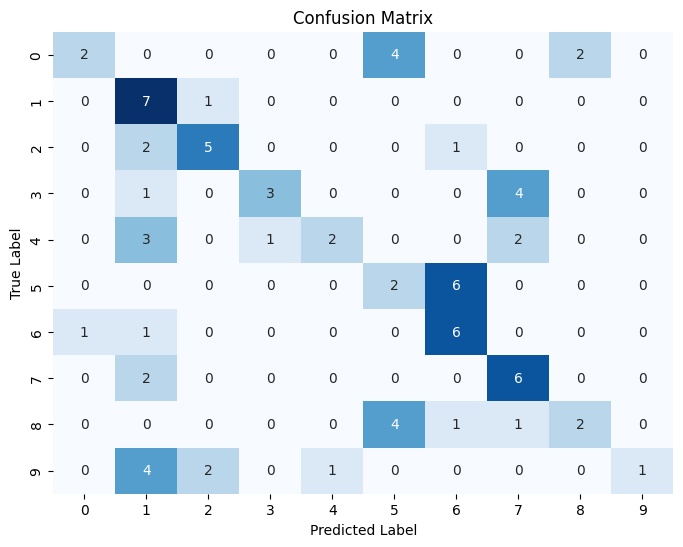

              precision    recall  f1-score   support

           0       0.67      0.25      0.36         8
           1       0.35      0.88      0.50         8
           2       0.62      0.62      0.62         8
           3       0.75      0.38      0.50         8
           4       0.67      0.25      0.36         8
           5       0.20      0.25      0.22         8
           6       0.43      0.75      0.55         8
           7       0.46      0.75      0.57         8
           8       0.50      0.25      0.33         8
           9       1.00      0.12      0.22         8

    accuracy                           0.45        80
   macro avg       0.56      0.45      0.42        80
weighted avg       0.56      0.45      0.42        80



In [162]:
acc, cm, report, y_true, y_pred = evaluate_model(model, custom_data_module.test_dataloader(), device)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# Print classification report with zero_division=1
print(classification_report(y_true, y_pred, zero_division=1))

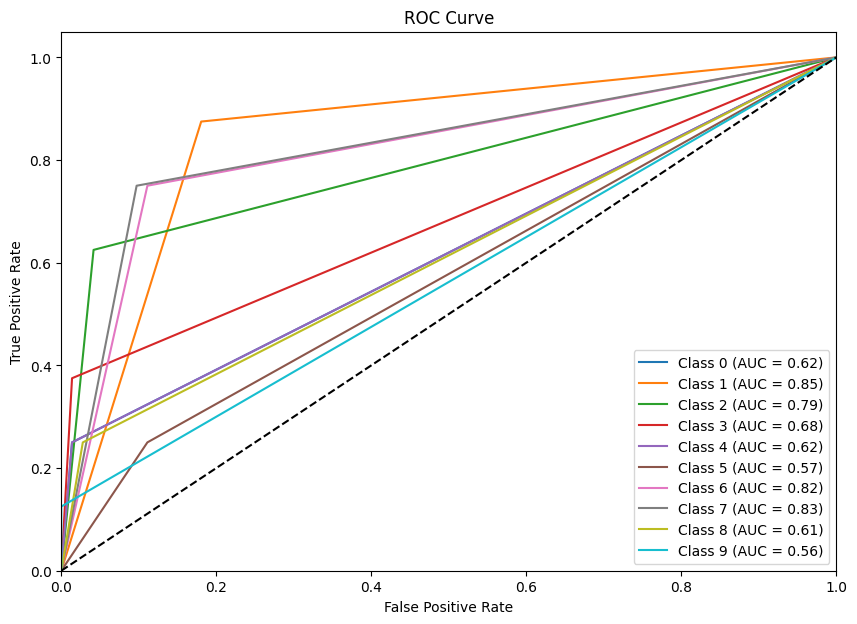

In [163]:
test_loader = custom_data_module.test_dataloader()
# Assuming you have `model`, `test_loader`, and `device` defined
auc_roc_curve(model, test_loader, device)

In [164]:
# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())

# Count the number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count the number of non-trainable parameters
non_trainable_params = total_params - trainable_params

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

Total parameters: 616074
Trainable parameters: 616074
Non-trainable parameters: 0


Heads in Attention block = 2

In [165]:
# Initialize the model
num_classes = 10
num_heads = 2 # You can change the number of heads as needed
model = AudioClassifierRegularized(num_classes, num_heads).to(device)

In [166]:
import wandb

model = SimpleCnn(num_classes = 10 , dropout_rate=0.5, weight_decay=0.001).to(device)

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.95)  # Use momentum here

val_loader = custom_data_module.val_dataloader()

# Define the early stopping parameters
patience = 25
best_val_loss = float('inf')
early_stop_counter = 0


wandb.init(
    project="Audio_Transformer", 
    config={
    "learning_rate": 0.0001,
    "architecture": "SimpleCnn",
    "dataset": "ESC",
    "epochs": 100,
    })

train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

num_epochs = 100

for epoch in range(num_epochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    model.train()
    for i, data in enumerate(custom_data_module.train_dataloader(), 0):
        inputs, labels = data

        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate and store training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_list.append(train_accuracy)

    # Calculate and store average training loss
    train_loss_list.append(train_loss / len(custom_data_module.train_dataloader()))

    wandb.log({"train_acc": train_accuracy, "train_loss": train_loss})

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data in custom_data_module.val_dataloader():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate and store validation accuracy
    val_accuracy = correct_val / total_val
    val_accuracy_list.append(val_accuracy)

    # Calculate and store average validation loss
    val_loss /= len(custom_data_module.val_dataloader())
    val_loss_list.append(val_loss)
    wandb.log({"val_acc": val_accuracy, "val_loss": val_loss})
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping!")
        break
wandb.finish()
print('Training Done')

Epoch 1/100, Training Accuracy: 0.23333333333333334, Validation Accuracy: 0.2125, Validation Loss: 2.4214489489793776
Epoch 2/100, Training Accuracy: 0.3875, Validation Accuracy: 0.4875, Validation Loss: 1.9111755669116974
Epoch 3/100, Training Accuracy: 0.5625, Validation Accuracy: 0.4375, Validation Loss: 2.381861151754856
Epoch 4/100, Training Accuracy: 0.5875, Validation Accuracy: 0.3875, Validation Loss: 2.4828650534152983
Epoch 5/100, Training Accuracy: 0.65, Validation Accuracy: 0.55, Validation Loss: 2.0742361336946487
Epoch 6/100, Training Accuracy: 0.7208333333333333, Validation Accuracy: 0.5125, Validation Loss: 1.7106254026293755
Epoch 7/100, Training Accuracy: 0.7708333333333334, Validation Accuracy: 0.425, Validation Loss: 2.004497338831425
Epoch 8/100, Training Accuracy: 0.7958333333333333, Validation Accuracy: 0.4125, Validation Loss: 2.324872266128659
Epoch 9/100, Training Accuracy: 0.8, Validation Accuracy: 0.45, Validation Loss: 2.034343126416206
Epoch 10/100, Traini

Training Done


In [167]:
test_loss, test_accuracy = evaluate_test(model, custom_data_module.test_dataloader(), criterion, device)
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')


Test Accuracy: 0.5, Test Loss: 1.7255473136901855


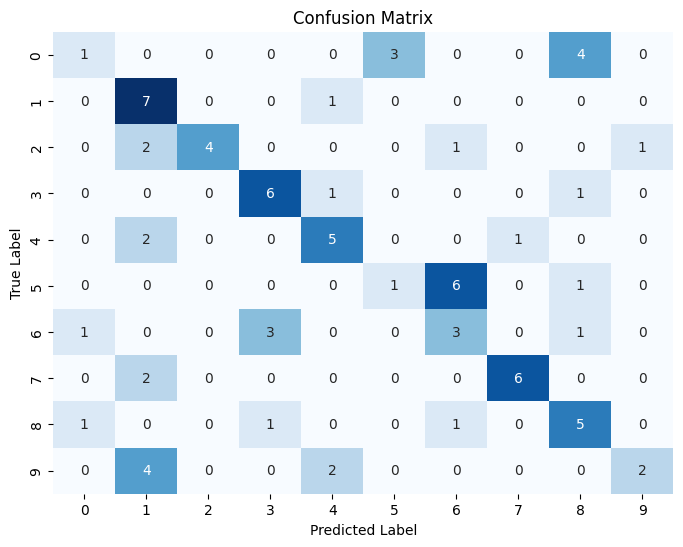

              precision    recall  f1-score   support

           0       0.33      0.12      0.18         8
           1       0.41      0.88      0.56         8
           2       1.00      0.50      0.67         8
           3       0.60      0.75      0.67         8
           4       0.56      0.62      0.59         8
           5       0.25      0.12      0.17         8
           6       0.27      0.38      0.32         8
           7       0.86      0.75      0.80         8
           8       0.42      0.62      0.50         8
           9       0.67      0.25      0.36         8

    accuracy                           0.50        80
   macro avg       0.54      0.50      0.48        80
weighted avg       0.54      0.50      0.48        80



In [168]:
acc, cm, report, y_true, y_pred = evaluate_model(model, custom_data_module.test_dataloader(), device)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# Print classification report with zero_division=1
print(classification_report(y_true, y_pred, zero_division=1))

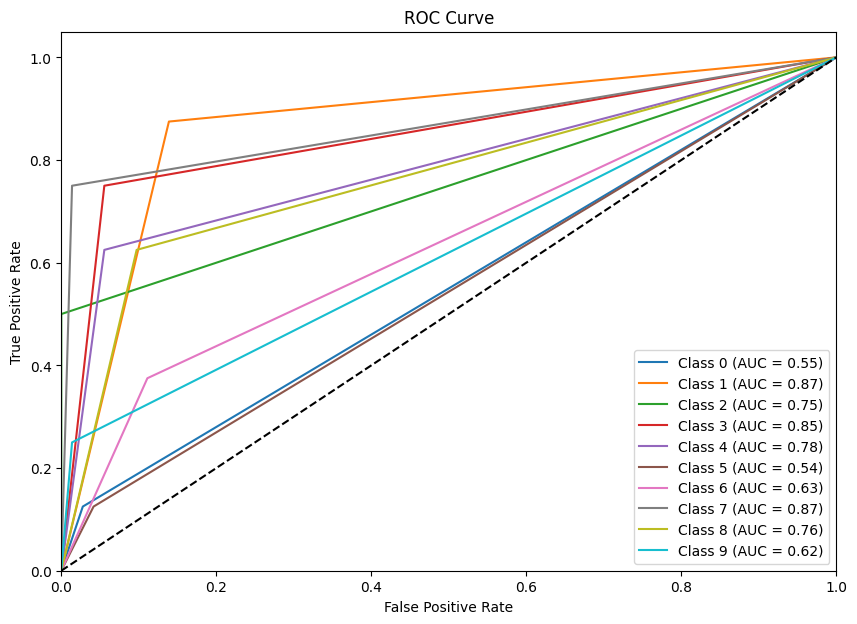

In [169]:
test_loader = custom_data_module.test_dataloader()
# Assuming you have `model`, `test_loader`, and `device` defined
auc_roc_curve(model, test_loader, device)

In [170]:
# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())

# Count the number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count the number of non-trainable parameters
non_trainable_params = total_params - trainable_params

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

Total parameters: 616074
Trainable parameters: 616074
Non-trainable parameters: 0


Heads in Attention block = 4

In [171]:
# Initialize the model
num_classes = 10
num_heads = 4 # You can change the number of heads as needed
model = AudioClassifierRegularized(num_classes, num_heads).to(device)

In [172]:
import wandb

model = SimpleCnn(num_classes = 10 , dropout_rate=0.5, weight_decay=0.001).to(device)

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.95)  # Use momentum here

val_loader = custom_data_module.val_dataloader()

# Define the early stopping parameters
patience = 25
best_val_loss = float('inf')
early_stop_counter = 0


wandb.init(
    project="Audio_Transformer", 
    config={
    "learning_rate": 0.0001,
    "architecture": "SimpleCnn",
    "dataset": "ESC",
    "epochs": 100,
    })

train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

num_epochs = 100

for epoch in range(num_epochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    model.train()
    for i, data in enumerate(custom_data_module.train_dataloader(), 0):
        inputs, labels = data

        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate and store training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_list.append(train_accuracy)

    # Calculate and store average training loss
    train_loss_list.append(train_loss / len(custom_data_module.train_dataloader()))

    wandb.log({"train_acc": train_accuracy, "train_loss": train_loss})

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data in custom_data_module.val_dataloader():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate and store validation accuracy
    val_accuracy = correct_val / total_val
    val_accuracy_list.append(val_accuracy)

    # Calculate and store average validation loss
    val_loss /= len(custom_data_module.val_dataloader())
    val_loss_list.append(val_loss)
    wandb.log({"val_acc": val_accuracy, "val_loss": val_loss})
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping!")
        break
wandb.finish()
print('Training Done')

Epoch 1/100, Training Accuracy: 0.24583333333333332, Validation Accuracy: 0.1875, Validation Loss: 2.9711839973926546
Epoch 2/100, Training Accuracy: 0.38333333333333336, Validation Accuracy: 0.4125, Validation Loss: 2.269709684420377
Epoch 3/100, Training Accuracy: 0.48333333333333334, Validation Accuracy: 0.4375, Validation Loss: 1.8620960913598537
Epoch 4/100, Training Accuracy: 0.55, Validation Accuracy: 0.4375, Validation Loss: 2.0474346417700873
Epoch 5/100, Training Accuracy: 0.6291666666666667, Validation Accuracy: 0.5375, Validation Loss: 1.864201734494418
Epoch 6/100, Training Accuracy: 0.7208333333333333, Validation Accuracy: 0.5, Validation Loss: 2.231012631673366
Epoch 7/100, Training Accuracy: 0.6875, Validation Accuracy: 0.4375, Validation Loss: 2.2417954221367835
Epoch 8/100, Training Accuracy: 0.6583333333333333, Validation Accuracy: 0.5, Validation Loss: 1.9825873956084252
Epoch 9/100, Training Accuracy: 0.6916666666666667, Validation Accuracy: 0.4, Validation Loss: 2

Training Done


In [173]:
test_loss, test_accuracy = evaluate_test(model, custom_data_module.test_dataloader(), criterion, device)
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')

Test Accuracy: 0.425, Test Loss: 1.9450163046518962


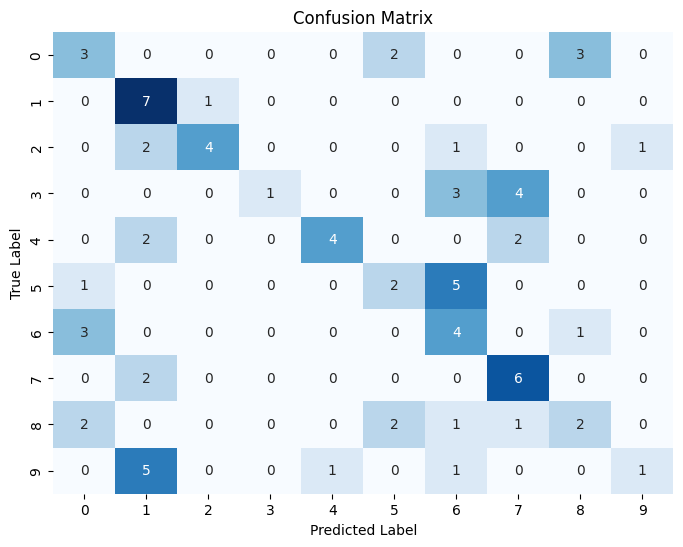

              precision    recall  f1-score   support

           0       0.33      0.38      0.35         8
           1       0.39      0.88      0.54         8
           2       0.80      0.50      0.62         8
           3       1.00      0.12      0.22         8
           4       0.80      0.50      0.62         8
           5       0.33      0.25      0.29         8
           6       0.27      0.50      0.35         8
           7       0.46      0.75      0.57         8
           8       0.33      0.25      0.29         8
           9       0.50      0.12      0.20         8

    accuracy                           0.42        80
   macro avg       0.52      0.42      0.40        80
weighted avg       0.52      0.42      0.40        80



In [174]:
acc, cm, report, y_true, y_pred = evaluate_model(model, custom_data_module.test_dataloader(), device)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# Print classification report with zero_division=1
print(classification_report(y_true, y_pred, zero_division=1))

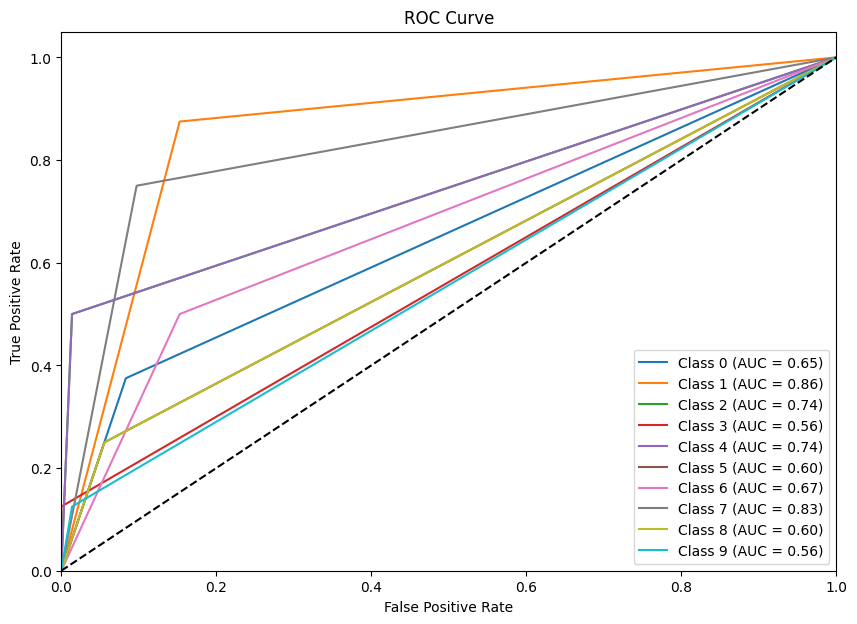

In [175]:
test_loader = custom_data_module.test_dataloader()
# Assuming you have `model`, `test_loader`, and `device` defined
auc_roc_curve(model, test_loader, device)

In [176]:
# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())

# Count the number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count the number of non-trainable parameters
non_trainable_params = total_params - trainable_params

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

Total parameters: 616074
Trainable parameters: 616074
Non-trainable parameters: 0
